In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.dwd_data import DWD_Dataset, Feature

import polars as pl
import pandas as pd

In [2]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"
DOUBLE_COL_FIG_SIZE = (15, 5)

In [5]:
dataset_model_1 = DWD_Dataset(
    source_path="../data/dwd",
    model=1,
    feature=Feature.PRECIPITATION
)
dataset_model_2 = DWD_Dataset(
    source_path="../data/dwd",
    model=2,
    feature=Feature.PRECIPITATION
)

                              call_time  station_id  precipitation_forecast  \
time                                                                          
2023-12-08 00:00:00 2023-12-08 00:10:00         257                     0.0   
2023-12-08 01:00:00 2023-12-08 00:10:00         257                     0.0   
2023-12-08 02:00:00 2023-12-08 00:10:00         257                     0.0   
2023-12-08 03:00:00 2023-12-08 00:10:00         257                     0.1   
2023-12-08 04:00:00 2023-12-08 00:10:00         257                     0.4   
...                                 ...         ...                     ...   
2024-01-25 19:00:00 2024-01-23 00:10:00         257                     0.0   
2024-01-25 20:00:00 2024-01-23 00:10:00         257                     0.4   
2024-01-25 21:00:00 2024-01-23 00:10:00         257                     0.3   
2024-01-25 22:00:00 2024-01-23 00:10:00         257                     0.2   
2024-01-25 23:00:00 2024-01-23 00:10:00         257 

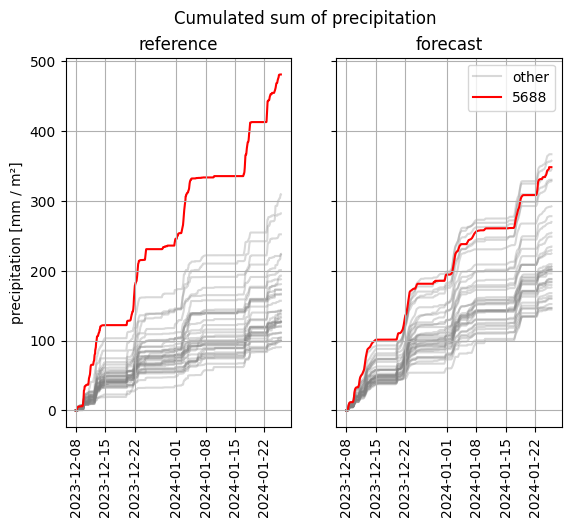

In [6]:
historical = dataset_model_1.get_merge()
historical = historical.sort_values(by="time")
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

for idx, (index, group) in enumerate(historical.groupby("station_id")):
    c = "r" if index == 5688 else "grey"
    alpha = 1 if index == 5688 else 0.3
    zorder = 0 if index != 5688 else 1
    label = index if index == 5688 else "other" if idx == 0 else ""
    
    temp_mean = group.groupby("time").mean()
    
    ax1.plot(
        temp_mean.index,
        temp_mean["precipitation_real"].values.cumsum(),
        label=label,
        c=c,
        zorder=zorder,
        alpha=alpha,
    )

    temp_max = group.groupby("time").max()
    ax2.plot(
        temp_max.index,
        temp_max["precipitation_forecast"].values.cumsum(),
        label=label,
        c=c,
        zorder=zorder,
        alpha=alpha,
    )

    
    print(group.groupby("time").max())

ax1.set_title("reference")
ax2.set_title("forecast")
fig.suptitle("Cumulated sum of precipitation")
ax1.set_ylabel("precipitation [mm / m²]")

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax2.grid()
ax1.grid()
ax2.legend()

First look at one specific station


In [ ]:
STATION_ID = 5688

In [7]:
import pandas


forecast1 = dataset_model_1.get_merge(station_id=STATION_ID).copy()
forecast2 = dataset_model_2.get_merge(station_id=STATION_ID).copy()


forecast1["call_time"] = forecast1["call_time"].dt.normalize()
forecast2["call_time"] = forecast2["call_time"].dt.normalize()

# num call times
num_call_times = 4

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)
call_times = sorted(forecast1["call_time"].unique())
for call_time in call_times[10 : 10 + num_call_times]:
    sub_df_forecast = forecast1[(forecast1["call_time"] == call_time)].sort_values(
        by="time"
    )
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    # axs[0].plot(t, sub_df_forecast["precipitation_real"], color="k", alpha=0.2)
    axs[0].plot(
        t,
        values,
        label=call_time.date(),
    )

    sub_df_forecast = forecast2[(forecast2["call_time"] == call_time)].sort_values(
        by="time"
    )
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"] / 3
    axs[1].plot(t, values, label=call_time.date())

# add historical context
# model 1
sub_df = forecast1[
    forecast1["call_time"].isin(call_times[10 : 10 + num_call_times])
    & (forecast1["station_id"] == STATION_ID)
]
min_time = min(sub_df["time"])
max_time = max(sub_df["time"])
real = forecast1[
    (forecast1["time"] <= max_time)
    & (forecast1["time"].values >= min_time)
    & (forecast1["station_id"] == STATION_ID)
].sort_values(by="time")
axs[0].plot(real["time"], real["precipitation_real"], zorder=0, c="k", alpha=0.7)
# model 2
sub_df = forecast2[
    forecast2["call_time"].isin(call_times[10 : 10 + num_call_times])
    & (forecast2["station_id"] == STATION_ID)
]
min_time = min(sub_df["time"])
max_time = max(sub_df["time"])
print(min_time, max_time)
real = forecast2[
    (forecast2["time"] <= max_time)
    & (forecast2["time"].values >= min_time)
    & (forecast2["station_id"] == STATION_ID)
].sort_values(by="time")
axs[1].plot(real["time"], real["precipitation_real"] / 3, zorder=0, c="k", alpha=0.7)


axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Forecast 1")
axs[0].set_ylabel("precipitation total [mm/(m² h)]")
axs[0].grid()
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Forecast 2")
axs[1].legend()
axs[1].grid()


fig.savefig(FIG_SAVE_BASE_PATH + "precipitation_forecast.pdf")

NameError: name 'STATION_ID' is not defined

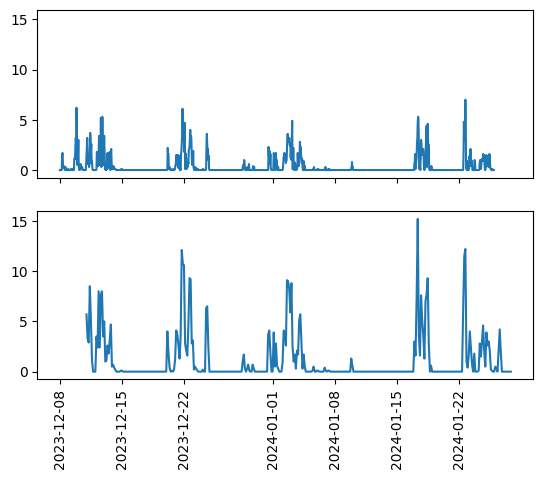

In [ ]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
real_data = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[0].plot(real_data["time"], real_data["precipitation_real"])
real_data = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[1].plot(real_data["time"], real_data["precipitation_real"])

axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)

Text(0.5, 0.98, 'Difference: Precipitation Forecast and Historical Precipitation for station: 5688')

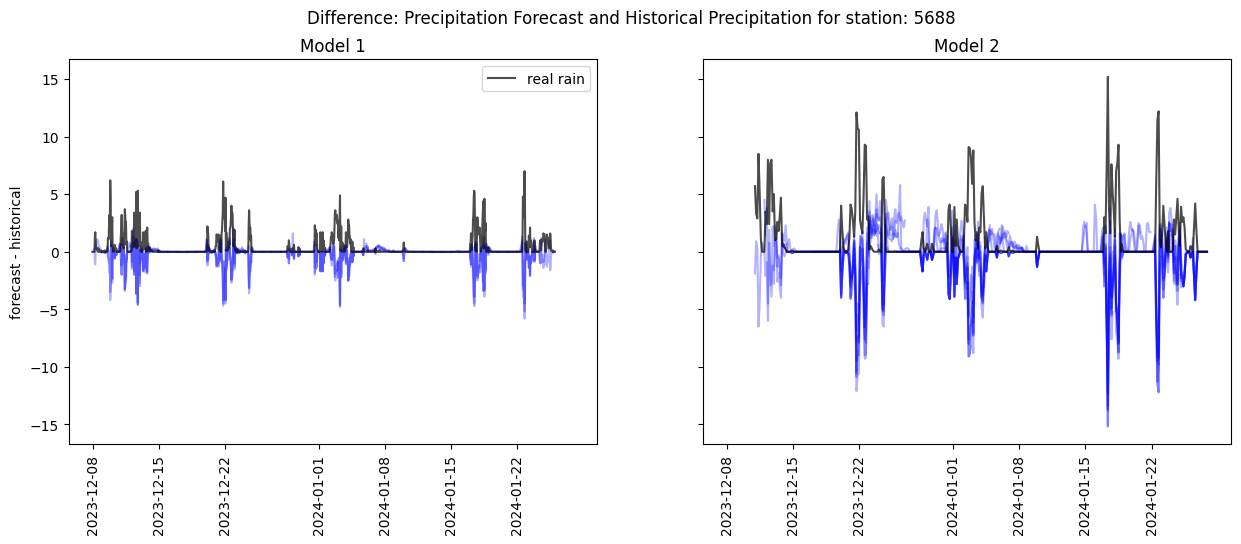

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE, sharey=True
)
merge_1 = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
merge2 = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")

# fig, ax1 = plt.subplots()

api_call_times = sorted(merge_1["call_time"].unique())
num_api_calls = len(api_call_times)
for idx, call_time in enumerate(api_call_times):
    sub_df_forecast = merge_1[merge_1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax1.plot(t, error, c="b", alpha=0.3)

    sub_df_forecast = merge2[merge2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax2.plot(t, error, c="b", alpha=0.3)

# plot real amount of rain
ax1.plot(
    merge_1["time"], merge_1["precipitation_real"], c="k", alpha=0.7, label="real rain"
)
ax2.plot(
    merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain"
)

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax2.set_title("Model 2")
ax1.legend()
fig.suptitle(
    "Difference: Precipitation Forecast and Historical Precipitation for station: "
    + str(STATION_ID)
)

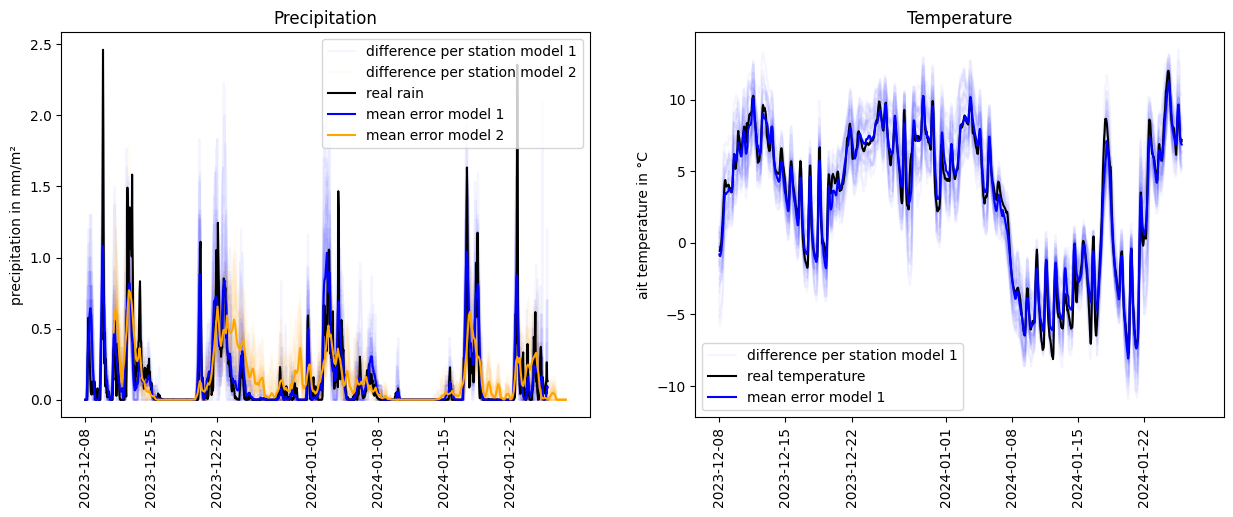

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE)
merge_1 = dataset_model_1.get_merge()
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


individual_groups = merge_1.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_forecast"],
        c="blue",
        alpha=0.04,
        label="difference per station model 1" if not idx else "",
    )

    ax2.plot(
        sub_df.index,
        sub_df["air_temperature_forecast"],
        c="blue",
        alpha=0.04,
        label="difference per station model 1" if not idx else "",
    )

individual_groups = merge2.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_forecast"] / 3,
        c="orange",
        alpha=0.04,
        label="difference per station model 2" if not idx else "",
    )


time_group = merge_1.groupby(["time"]).mean()
ax1.plot(time_group.index, time_group["precipitation_real"], c="k", label="real rain")
ax1.plot(
    time_group.index,
    time_group["precipitation_forecast"],
    c="b",
    label="mean error model 1",
)


time_group = merge2.groupby(["time"]).mean()
ax1.plot(
    time_group.index,
    time_group["precipitation_forecast"] / 3,
    c="orange",
    label="mean error model 2",
)

time_group = merge_1.groupby(["time"]).mean()
ax2.plot(
    time_group.index,
    time_group["air_temperature_real"],
    c="k",
    label="real temperature",
)
ax2.plot(
    time_group.index,
    time_group["air_temperature_forecast"],
    c="b",
    label="mean error model 1",
)


# ax1.plot(merge1.index, merge1["precipitation_real"], c="k", label="real_rain")
#
#
# ax2.plot(merge2.index, merge2["precipitation_error"], c="b", label="mean error")
# ax2.plot(merge2.index, merge2["precipitation_real"], c="k", label="real_rain")


#
# api_call_times = sorted(merge1["call_time"].unique())
# num_api_calls = len(api_call_times)
# for idx, call_time in enumerate(api_call_times):
#     sub_df_forecast = merge1[merge1["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax1.plot(t, error, c="b", alpha=0.3)
#
#
#     sub_df_forecast = merge2[merge2["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax2.plot(t, error, c="b", alpha=0.3)
#
# # plot real amount of rain
# ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
# ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
#
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("precipitation in mm/m²")
ax2.set_ylabel("ait temperature in °C")
ax1.set_title("Precipitation")
ax2.set_title("Temperature")
ax1.legend()
ax2.legend()
# fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))
#
# # compute correlation

what is the relative error $(forecast - historical) / historical$


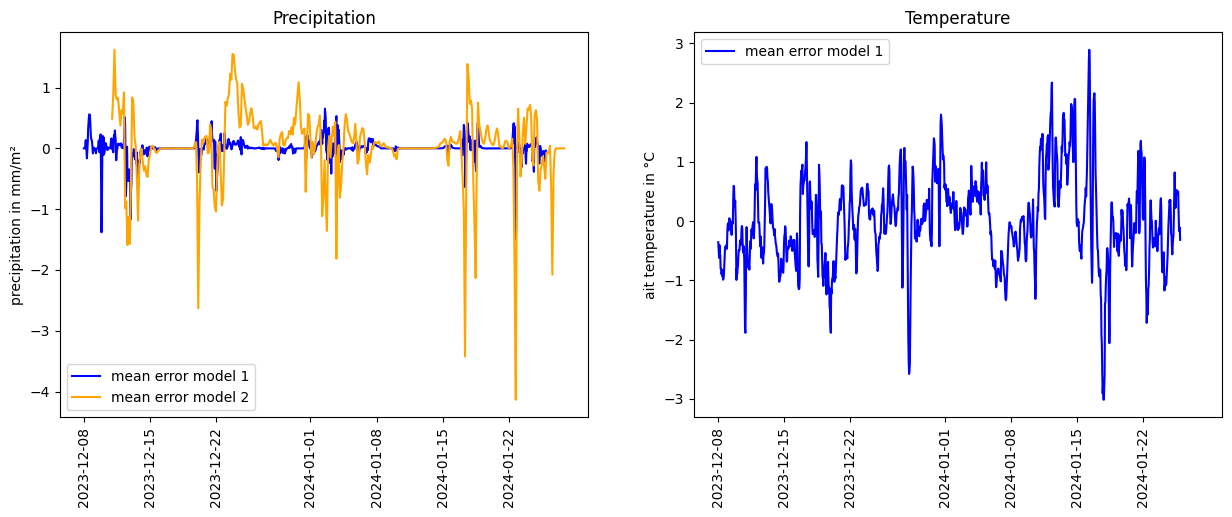

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE)
merge_1 = dataset_model_1.get_merge()
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


individual_groups = merge_1.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    # ax1.plot(sub_df.index, sub_df["precipitation_error"] / (sub_df["precipitation_real"] + 1e-16), c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

    # ax2.plot(sub_df.index, sub_df["air_temperature_error"], c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

individual_groups = merge2.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    # ax1.plot(sub_df.index, sub_df["precipitation_error"] / (sub_df["precipitation_real"] + 1e-16), c="orange", alpha=0.04, label="difference per station model 2" if not idx else "")


time_group = merge_1.groupby(["time"]).mean()
# ax1.plot(time_group.index, time_group["precipitation_real"], c="k", label="real rain")
ax1.plot(
    time_group.index,
    time_group["precipitation_error"],
    c="b",
    label="mean error model 1",
)


time_group = merge2.groupby(["time"]).mean()
ax1.plot(
    time_group.index,
    time_group["precipitation_error"],
    c="orange",
    label="mean error model 2",
)

time_group = merge_1.groupby(["time"]).mean()
# ax2.plot(time_group.index, time_group["air_temperature_real"], c="k", label="real temperature")
ax2.plot(
    time_group.index,
    time_group["air_temperature_error"],
    c="b",
    label="mean error model 1",
)


# ax1.plot(merge1.index, merge1["precipitation_real"], c="k", label="real_rain")
#
#
# ax2.plot(merge2.index, merge2["precipitation_error"], c="b", label="mean error")
# ax2.plot(merge2.index, merge2["precipitation_real"], c="k", label="real_rain")


#
# api_call_times = sorted(merge1["call_time"].unique())
# num_api_calls = len(api_call_times)
# for idx, call_time in enumerate(api_call_times):
#     sub_df_forecast = merge1[merge1["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax1.plot(t, error, c="b", alpha=0.3)
#
#
#     sub_df_forecast = merge2[merge2["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax2.plot(t, error, c="b", alpha=0.3)
#
# # plot real amount of rain
# ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
# ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
#
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("precipitation in mm/m²")
ax2.set_ylabel("ait temperature in °C")
ax1.set_title("Precipitation")
ax2.set_title("Temperature")
ax1.legend()
ax2.legend()
# fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))
#
# # compute correlation

What is the general trend of the error in model 1 and model 2


In [ ]:
merge_1 = dataset_model_1.get_merge()

call_times = sorted(merge_1["call_time"].unique())
station_ids = sorted(merge_1["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge_1[
            (merge_1["call_time"] == call_time) & (merge_1["station_id"] == station_id)
        ]

        if len(sub_df_forecast) < 72:
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"].values[:72])

    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_1 = np.stack(result)

In [ ]:
merge2 = dataset_model_2.get_merge()

call_times = sorted(merge2["call_time"].unique())
station_ids = sorted(merge2["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge2[
            (merge2["call_time"] == call_time) & (merge2["station_id"] == station_id)
        ]

        if (
            len(sub_df_forecast) < 56
        ):  # 56 is how many samples are expected in a forecast of model 2
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"][:56])

    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_2 = np.stack(result)
error_mat_model_2 /= 3

forecast 1 mean:  0.14713028631468347
coef model 1
[0.12445495 0.00063874]
forecast 2 mean:  0.1620769785605826
coef model 2
[0.1480528  0.00050997]


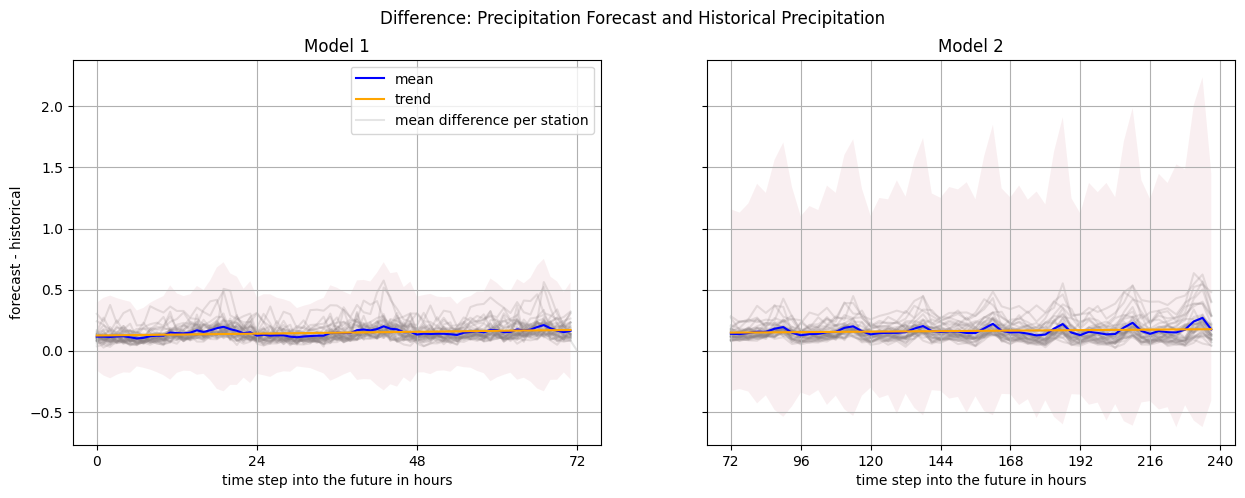

In [ ]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# absolute values
merge_1["precipitation_error"] = merge_1["precipitation_error"].abs()
merge2["precipitation_error"] = merge2["precipitation_error"].abs()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
# fig, ax1 = plt.subplots()
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


# plot means
mean_time_delta = merge_1.groupby("time_delta").mean().iloc[:-1]
t = mean_time_delta.index.values / (3600 * 1e9)  # to hours
ax1.plot(t, mean_time_delta["precipitation_error"], c="b", label="mean")
print("forecast 1 mean: ", (mean_time_delta["precipitation_error"]).mean())

# trend regression
x = np.arange(len(mean_time_delta))[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = (
    np.linalg.inv(x_aug.T @ x_aug)
    @ x_aug.T
    @ mean_time_delta["precipitation_error"].values
)
regression = x_aug @ regression_coef
ax1.plot(t, regression, color="orange", label="trend")
print("coef model 1")
print(regression_coef)

# plot std
std_time_delta = merge_1.groupby("time_delta").std().iloc[:-1]
t = std_time_delta.index.values / (3600 * 1e9)  # to hours
t = t.astype(int)
lower = mean_time_delta["precipitation_error"].values - std_time_delta["precipitation_error"].values
upper = mean_time_delta["precipitation_error"].values + std_time_delta["precipitation_error"].values
ax1.fill_between(
    t,
    lower, 
    upper,
    # c="b",
    # label="std",
    alpha=0.1
)


mean_time_delta = merge2.groupby("time_delta").mean()
t = mean_time_delta.index.values / (3600 * 1e9)  # to hours
ax2.plot(t, mean_time_delta["precipitation_error"] / 3, c="b", label="mean")
print("forecast 2 mean: ", (mean_time_delta["precipitation_error"] / 3).mean())
# trend regression
x = np.arange(len(mean_time_delta))[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = (
    np.linalg.inv(x_aug.T @ x_aug)
    @ x_aug.T
    @ mean_time_delta["precipitation_error"].values
    / 3
)
regression = x_aug @ regression_coef
ax2.plot(t, regression, color="orange", label="trend")
print("coef model 2")
print(regression_coef)

# plot std 
std_time_delta = merge2.groupby("time_delta").std()
t = std_time_delta.index.values / (3600 * 1e9)  # to hours
t = t.astype(int)
lower = mean_time_delta["precipitation_error"].values - std_time_delta["precipitation_error"].values
upper = mean_time_delta["precipitation_error"].values + std_time_delta["precipitation_error"].values
ax2.fill_between(
    t,
    lower, 
    upper,
    # c="b",
    # label="std",
    alpha=0.1
)



# plot grey lines per station
mean_time_delta = merge_1.groupby(["time_delta", "station_id"]).mean().iloc[:-1]
for idx, station_id in enumerate(merge_1["station_id"].unique()):
    sub_df = mean_time_delta.xs(station_id, level="station_id")
    t = sub_df.index.values / (3600 * 1e9)  # to hours
    ax1.plot(
        t,
        sub_df["precipitation_error"],
        label="mean difference per station" if idx == 0 else "",
        color="grey",
        alpha=0.2,
        zorder=0,
    )

# plot grey lines per station
mean_time_delta = merge2.groupby(["time_delta", "station_id"]).mean().iloc[:-1]
for idx, station_id in enumerate(merge2["station_id"].unique()):
    sub_df = mean_time_delta.xs(station_id, level="station_id")
    t = sub_df.index.values / (3600 * 1e9)  # to hours
    ax2.plot(
        t,
        sub_df["precipitation_error"] / 3,
        label="mean difference per station" if idx == 0 else "",
        color="grey",
        alpha=0.2,
        zorder=0,
    )


ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax1.set_xlabel("time step into the future in hours")
ax1.set_xticks(np.linspace(0, 72, 4, dtype=int), np.linspace(0, 72, 4, dtype=int))
ax1.grid()
ax1.legend()

ax2.set_title("Model 2")
ax2.set_xlabel("time step into the future in hours")
ax2.set_xticks(
    np.linspace(0, 56, 8, dtype=int) * 3 + 72, np.linspace(0, 56, 8, dtype=int) * 3 + 72
)
ax2.grid()


# TODO: one plot?????
# TODO: what is more important: graphic with grey line or tube of standard diviation?
# TODO: This or the absolute error

In [28]:
merge_1 = dataset_model_1.get_merge()
merge_2 = dataset_model_2.get_merge()


N_BOOT = 10000
boot_mean = np.empty((N_BOOT, 2))
for i in tqdm(range(N_BOOT)):
    boot_mean[i, 0] = np.random.choice(merge_1["precipitation_error"].values, replace=True, size=len(merge_1)).std()
    boot_mean[i, 1] = np.random.choice(merge_2["precipitation_error"].values / 3, replace=True, size=len(merge_2)).std()

boot_mean.mean(axis=0)

100%|██████████| 10000/10000 [00:16<00:00, 610.86it/s]


array([0.39154259, 0.35282062])

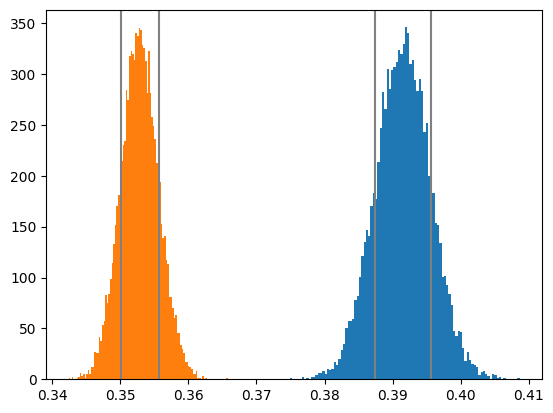

In [29]:
plt.hist(boot_mean[:, 0], bins=100)
plt.hist(boot_mean[:, 1], bins=100)
boot_mean.mean(axis=0)

plt.axvline(boot_mean.mean(axis=0)[0] - boot_mean.std(axis=0)[0], color="grey")
plt.axvline(boot_mean.mean(axis=0)[0] + boot_mean.std(axis=0)[0], color="grey")

plt.axvline(boot_mean.mean(axis=0)[1] - boot_mean.std(axis=0)[1], color="grey")
plt.axvline(boot_mean.mean(axis=0)[1] + boot_mean.std(axis=0)[1], color="grey")

In [80]:
merge_1 = dataset_model_1.get_merge()
merge_2 = dataset_model_2.get_merge()


N_BOOT = 10000
boot_mean = np.empty((N_BOOT, 2))
for i in tqdm(range(N_BOOT)):
    boot_mean[i, 0] = np.random.choice(np.abs(merge_1["precipitation_error"].values), replace=True, size=len(merge_1)).std()
    boot_mean[i, 1] = np.random.choice(np.abs(merge_2["precipitation_error"].values / 3), replace=True, size=len(merge_1)).std()

boot_mean.mean(axis=0)

100%|██████████| 10000/10000 [00:19<00:00, 508.62it/s]


array([0.36290096, 0.31368585])

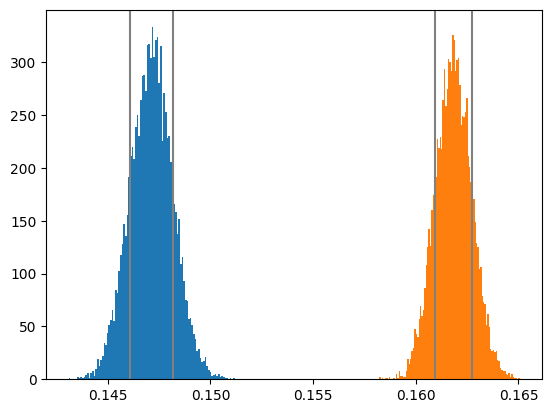

In [24]:
plt.hist(boot_mean[:, 0], bins=100)
plt.hist(boot_mean[:, 1], bins=100)
boot_mean.mean(axis=0)

plt.axvline(boot_mean.mean(axis=0)[0] - boot_mean.std(axis=0)[0], color="grey")
plt.axvline(boot_mean.mean(axis=0)[0] + boot_mean.std(axis=0)[0], color="grey")

plt.axvline(boot_mean.mean(axis=0)[1] - boot_mean.std(axis=0)[1], color="grey")
plt.axvline(boot_mean.mean(axis=0)[1] + boot_mean.std(axis=0)[1], color="grey")

In [56]:
merge_1 = dataset_model_1.get_merge().copy()
merge_2 = dataset_model_2.get_merge().copy()

# absolute values
# merge_1["precipitation_error"] = merge_1["precipitation_error"].abs()
# merge_2["precipitation_error"] = merge_2["precipitation_error"].abs()

# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge_2["call_time"] = merge_2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge_2["time"] - merge_2["call_time"]
merge_2.insert(len(merge_2.columns), "time_delta", time_delta)


N_BOOT = 10000

time_delta_std_1 = np.empty((len(merge_1["time_delta"].unique()), N_BOOT, 2))
for idx, (_, group) in enumerate(tqdm(merge_1.groupby("time_delta"))):
    for i in range(N_BOOT):
        time_delta_std_1[idx, i, 0] = np.random.choice(group["precipitation_error"].values, replace=True, size=len(group)).std()
        time_delta_std_1[idx, i, 1] = np.random.choice(np.abs(group["precipitation_error"].values), replace=True, size=len(group)).std()

time_delta_std_2 = np.empty((len(merge_2["time_delta"].unique()), N_BOOT, 2))
for idx, (_, group) in enumerate(tqdm(merge_2.groupby("time_delta"))):
    for i in range(N_BOOT):
        time_delta_std_2[idx, i, 0] = np.random.choice(group["precipitation_error"].values / 3, replace=True, size=len(group)).std()
        time_delta_std_2[idx, i, 1] = np.random.choice(np.abs(group["precipitation_error"].values / 3), replace=True, size=len(group)).std()


  0%|          | 0/73 [00:00<?, ?it/s]

100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


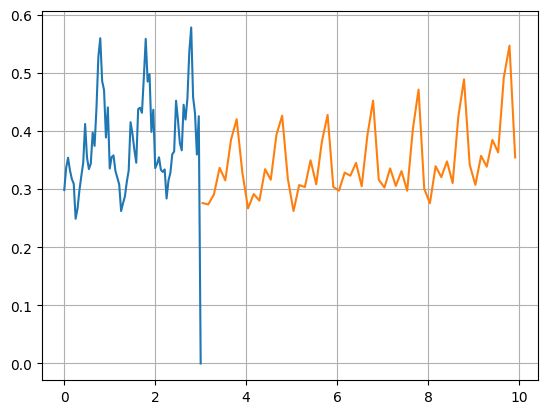

In [49]:
plt.plot(np.arange(73) / 24, time_delta_std_1.mean(axis=1))
plt.plot((np.arange(56) * 3 + 73) / 24, time_delta_std_2.mean(axis=1))
plt.grid()

forecast 1 mean:  0.0036757945889151567
forecast 2 mean:  0.011458654099118278
forecast 1 mean:  0.14713028631468347
forecast 2 mean:  0.1620769785605826


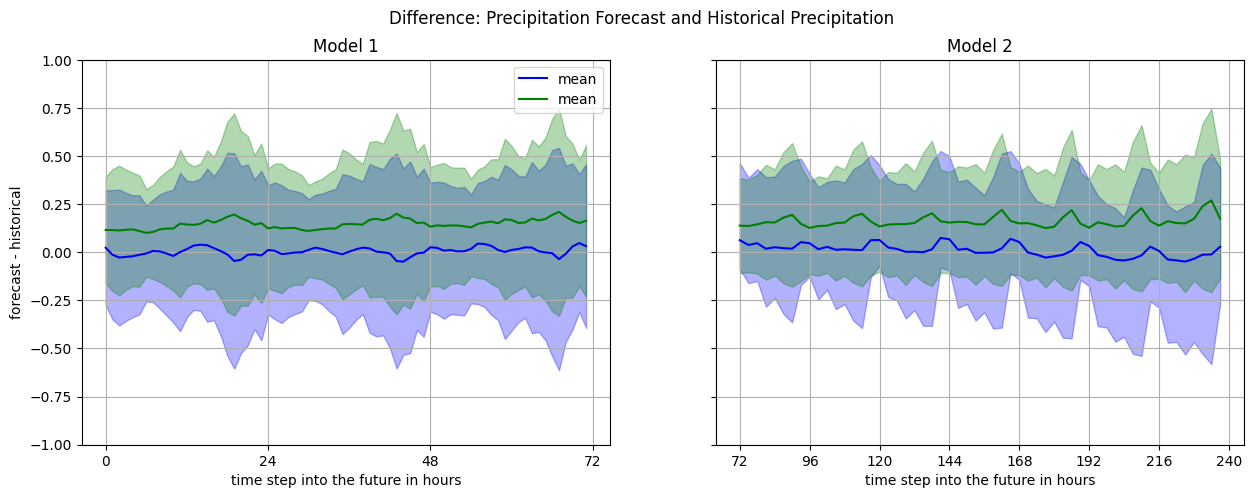

In [79]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
# fig, ax1 = plt.subplots()
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# plot means
mean_time_delta = merge_1.groupby("time_delta").mean().iloc[:-1]
t = (mean_time_delta.index.values / (3600 * 1e9)).astype(float)  # to hours
ax1.plot(t, mean_time_delta["precipitation_error"], c="b", label="mean")
print("forecast 1 mean: ", (mean_time_delta["precipitation_error"]).mean())
ax1.fill_between(
    t,
    mean_time_delta["precipitation_error"] - time_delta_std_1.mean(axis=1)[:-1, 0],
    mean_time_delta["precipitation_error"] + time_delta_std_1.mean(axis=1)[:-1, 0],
    alpha=0.3,
    color="b"
)

mean_time_delta = merge2.groupby("time_delta").mean()
t = (mean_time_delta.index.values / (3600 * 1e9)).astype(float)  # to hours
ax2.plot(t, mean_time_delta["precipitation_error"] / 3, c="b", label="mean")
print("forecast 2 mean: ", (mean_time_delta["precipitation_error"] / 3).mean())
ax2.fill_between(
    t,
    mean_time_delta["precipitation_error"] - time_delta_std_2.mean(axis=1)[:, 0],
    mean_time_delta["precipitation_error"] + time_delta_std_2.mean(axis=1)[:, 0],
    alpha=0.3,
    color="b"
)


# absolute values
merge_1["precipitation_error"] = merge_1["precipitation_error"].abs()
merge2["precipitation_error"] = merge2["precipitation_error"].abs()

# plot means
mean_time_delta = merge_1.groupby("time_delta").mean().iloc[:-1]
t = (mean_time_delta.index.values / (3600 * 1e9)).astype(float)  # to hours
ax1.plot(t, mean_time_delta["precipitation_error"], c="green", label="mean")
print("forecast 1 mean: ", (mean_time_delta["precipitation_error"]).mean())
ax1.fill_between(
    t,
    mean_time_delta["precipitation_error"] - time_delta_std_1.mean(axis=1)[:-1, 1],
    mean_time_delta["precipitation_error"] + time_delta_std_1.mean(axis=1)[:-1, 1],
    alpha=0.3,
    color="g"
)


mean_time_delta = merge2.groupby("time_delta").mean()
t = (mean_time_delta.index.values / (3600 * 1e9)).astype(float)  # to hours
ax2.plot(t, mean_time_delta["precipitation_error"] / 3, c="green", label="mean")
print("forecast 2 mean: ", (mean_time_delta["precipitation_error"] / 3).mean())
ax2.fill_between(
    t,
    mean_time_delta["precipitation_error"] / 3 - time_delta_std_2.mean(axis=1)[:, 1],
    mean_time_delta["precipitation_error"] / 3 + time_delta_std_2.mean(axis=1)[:, 1],
    alpha=0.3,
    color="g"
)



ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax1.set_xlabel("time step into the future in hours")
ax1.set_xticks(np.linspace(0, 72, 4, dtype=int), np.linspace(0, 72, 4, dtype=int))
ax1.grid()
ax1.set_ylim((-1, 1))
ax1.legend()

ax2.set_title("Model 2")
ax2.set_xlabel("time step into the future in hours")
ax2.set_xticks(
    np.linspace(0, 56, 8, dtype=int) * 3 + 72, np.linspace(0, 56, 8, dtype=int) * 3 + 72
)
ax2.grid()


# TODO: one plot?????
# TODO: what is more important: graphic with grey line or tube of standard diviation?
# TODO: This or the absolute error

FFT


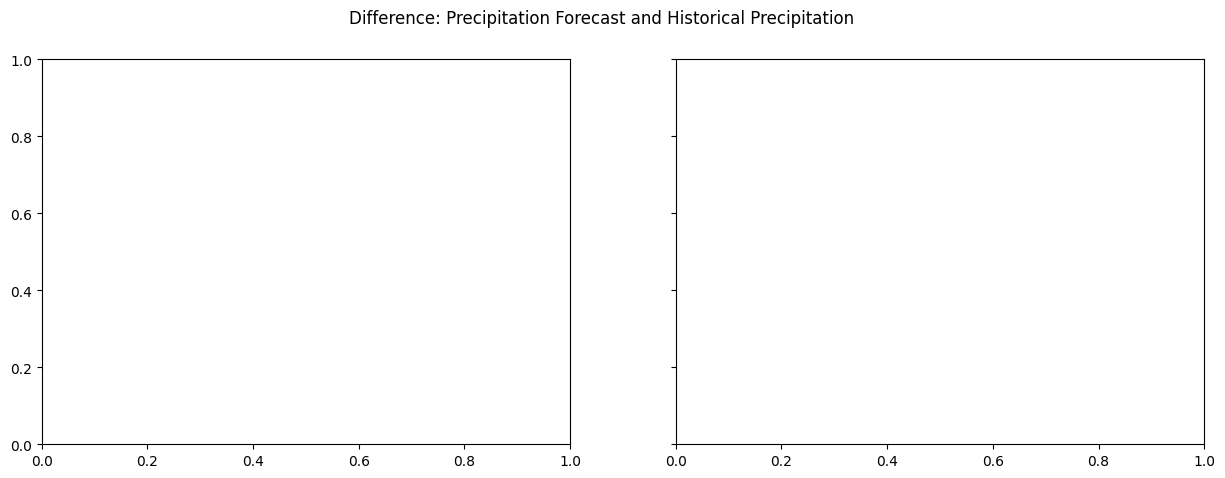

In [ ]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
# fig, ax1 = plt.subplots()
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()


# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)

get confidence intervalls of the mean curve (blue) with bootstrap


In [ ]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000

# MODEL 1

flatten_errors_1 = np.concatenate(error_mat_model_1, axis=0)
N_1 = len(
    flatten_errors_1
)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_1 = np.empty((flatten_errors_1.shape[1], N_BOOT))

for idx, time_step_error in enumerate(
    tqdm(flatten_errors_1.T, desc="Bootstrap Model 1")
):
    simulated_errors = np.random.choice(
        time_step_error, size=(N_BOOT, N_1), replace=True
    )
    mean_1 = simulated_errors.mean(axis=1)
    # print(boot_strap_means_1.shape, mean.shape)
    boot_strap_means_1[idx] = simulated_errors.mean(axis=1)
# MODEL 2

flatten_errors_2 = np.concatenate(error_mat_model_2, axis=0)
N_2 = len(
    flatten_errors_2
)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_2 = np.empty((flatten_errors_2.shape[1], N_BOOT))

for idx, time_step_error in enumerate(
    tqdm(flatten_errors_2.T, desc="Bootstrap Model 2")
):
    simulated_errors = np.random.choice(
        time_step_error, size=(N_BOOT, N_1), replace=True
    )
    mean_1 = simulated_errors.mean(axis=1)
    boot_strap_means_2[idx] = simulated_errors.mean(axis=1)

Bootstrap Model 2: 100%|██████████| 56/56 [00:10<00:00,  5.26it/s]


In [ ]:
boot_strap_means_2.shape

(56, 10000)

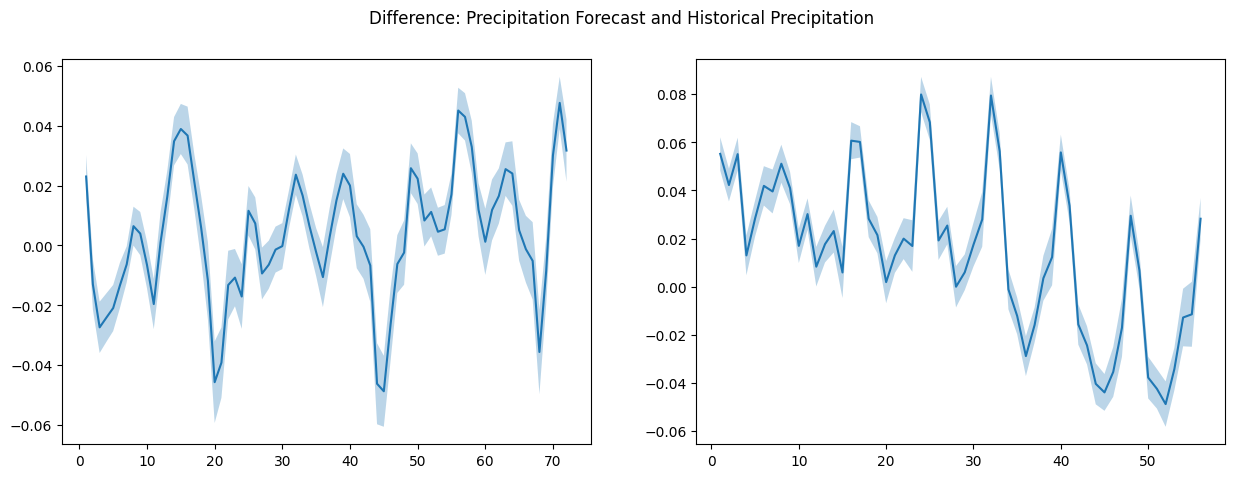

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

x_axis = np.arange(1, 73)
mean_1 = boot_strap_means_1.mean(axis=1)
std_1 = boot_strap_means_1.std(axis=1)

ax1.plot(x_axis, mean_1)
ax1.fill_between(x_axis, mean_1 - std_1, mean_1 + std_1, alpha=0.3)


x_axis = np.arange(1, 57)
mean_2 = boot_strap_means_2.mean(axis=1)
std_2 = boot_strap_means_2.std(axis=1)

ax2.plot(x_axis, mean_2)
ax2.fill_between(x_axis, mean_2 - std_2, mean_2 + std_2, alpha=0.3)

# TODO: ellipse plots????

look at the covariance between the estimated mean and the estimated standard variance.


Correlation matrix between mean and standard variance for model 1
[[0.03432172 0.00113242]
 [0.00113242 0.00649843]]
Correlation matrix between mean and standard variance for model 2
[[0.07107536 0.00583205]
 [0.00583205 0.00408599]]


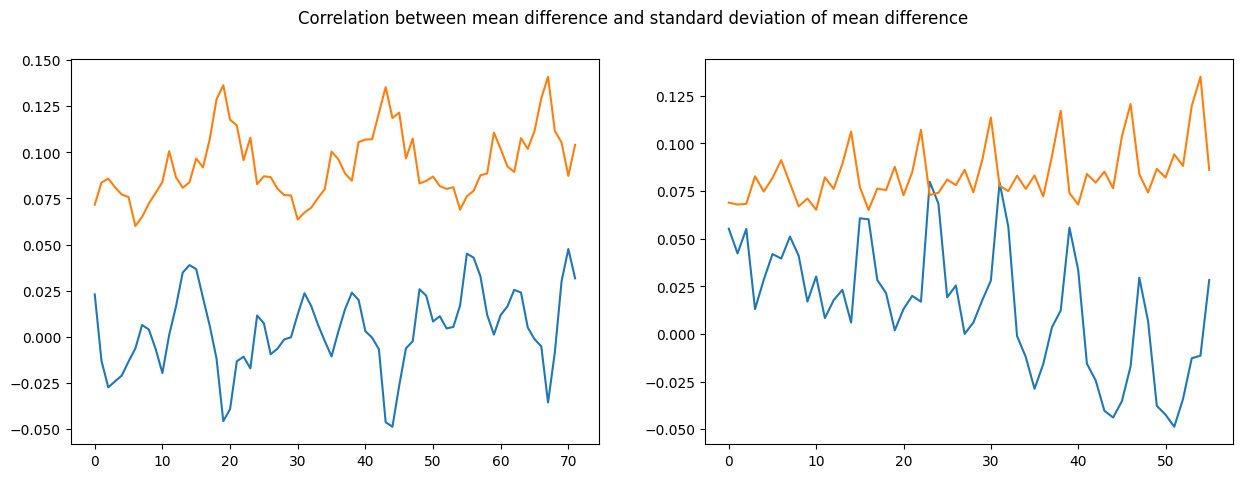

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle(
    "Correlation between mean difference and standard deviation of mean difference"
)


ax1.plot(mean_1)
ax1.plot(std_1 * 10)

estimator_properties = np.stack([mean_1, std_1]).T
print("Correlation matrix between mean and standard variance for model 1")
print(estimator_properties.T @ estimator_properties)

ax2.plot(mean_2)
ax2.plot(std_2 * 10)

estimator_properties = np.stack([mean_2, std_2]).T
print("Correlation matrix between mean and standard variance for model 2")
print(estimator_properties.T @ estimator_properties)

Do a FFT on errors:


Do fft: 100%|██████████| 1/1 [00:00<00:00, 8019.70it/s]


Text(0.5, 0, 'Frequency in 1 / day ')

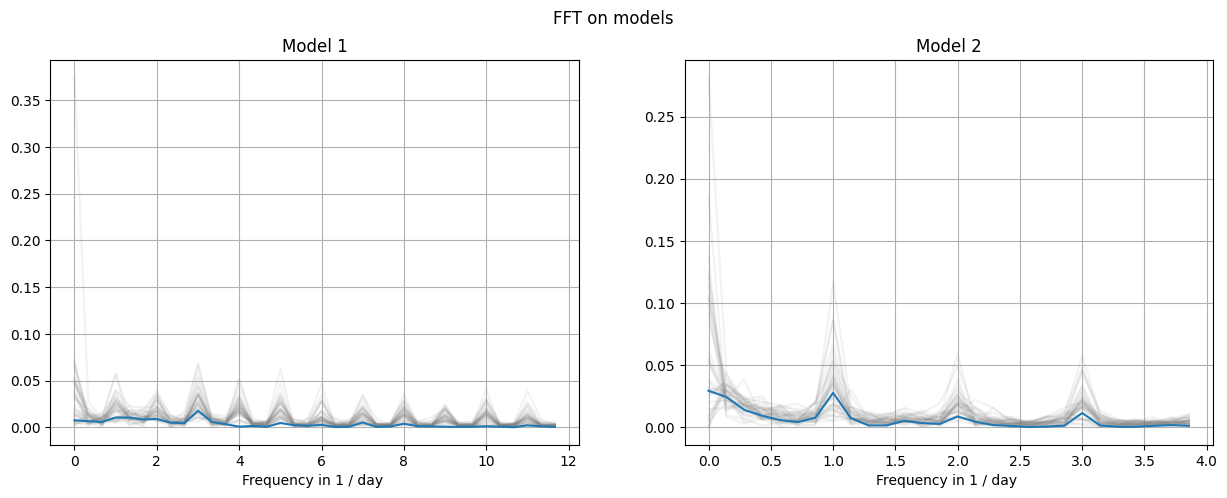

In [ ]:
from typing import Tuple
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt


def do_fft(time_series: np.ndarray, period: float = 1) -> Tuple[np.ndarray, np.ndarray]:
    """perform fft on given time series

    Args:
        time_series (np.ndarray): shape (num_series, length of series)
        period (float, optional): _description_. Defaults to 1.

    Returns:
        Tuple[np.ndarray, np.ndarray]: _description_
    """
    # Number of sample points
    N = time_series.shape[-1]
    # sample spacing

    result = np.empty((time_series.shape[0], time_series.shape[1] // 2))
    for idx, station_error in enumerate(tqdm(time_series, desc="Do fft")):
        yf = fft(station_error)
        yf = 2.0 / N * np.abs(yf[0 : N // 2])
        result[idx] = yf

    xf = fftfreq(N, period)[: N // 2]
    return xf, result


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("FFT on models")

# station_errors_model_1 = np.concatenate(error_mat_model_1, axis=0)
station_errors_model_1 = error_mat_model_1.mean(axis=0)
T = 3600
xf, yf = do_fft(station_errors_model_1, T)
xf *= T * 24
ax1.plot(xf, yf.T, color="grey", alpha=0.1)
ax1.plot(xf, do_fft(station_errors_model_1.mean(axis=0)[None], T)[1].T)


station_errors_model_2 = error_mat_model_2.mean(axis=0)
T = 3600 * 3
xf, yf = do_fft(station_errors_model_2, T)
xf *= T * 8
ax2.plot(xf, yf.T, color="grey", alpha=0.1)
ax2.plot(xf, do_fft(station_errors_model_2.mean(axis=0)[None], T)[1].T)

# convert xf
# xf *= 3600 * 24
# ax2.plot(xf, yf.T, c="grey", alpha=0.01)
# ax2.plot(xf, yf.mean(axis=0))
# ax2.plot(xf, yf.mean(axis=0))

ax1.grid()
ax1.set_title("Model 1")
ax1.set_xlabel("Frequency in 1 / day ")
ax2.grid()
ax2.set_title("Model 2")
ax2.set_xlabel("Frequency in 1 / day ")

Is one call time prone to errors


correlation between expected absolute difference depending on call time
Model 1
                        precipitation_real  precipitation_forecast
precipitation_real                1.000000                0.929257
precipitation_forecast            0.929257                1.000000

 Model 2
                        precipitation_real  precipitation_forecast
precipitation_real                 1.00000                 0.64842
precipitation_forecast             0.64842                 1.00000


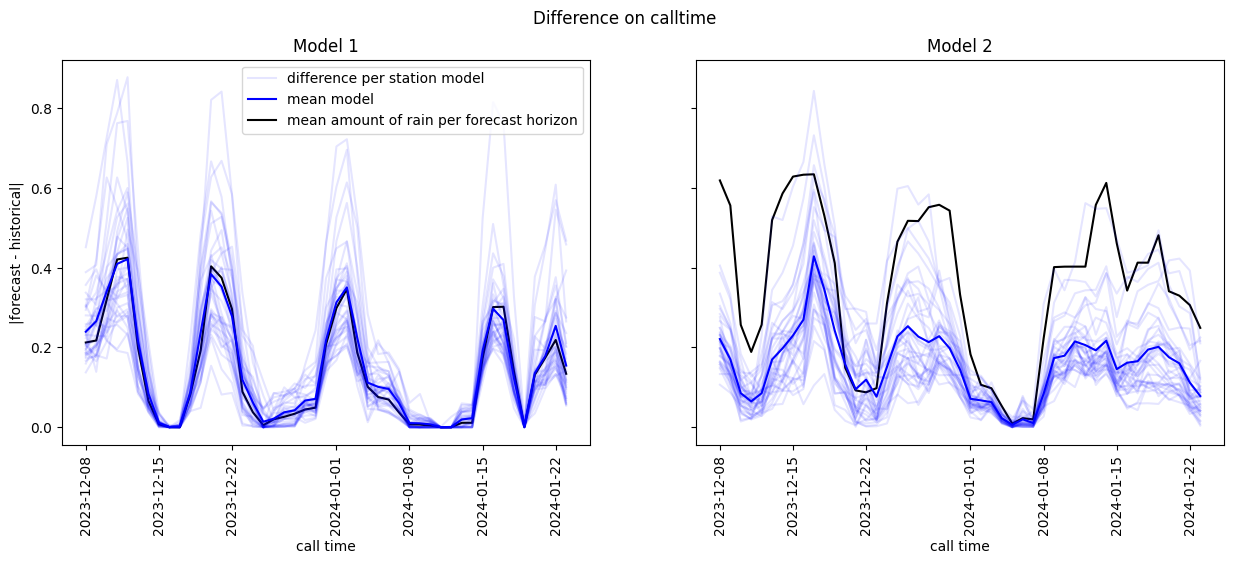

In [ ]:
merge_1 = dataset_model_1.get_merge()
merge_1["precipitation_error"] = merge_1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
merge2["precipitation_error"] = merge2["precipitation_error"].abs()


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
fig.suptitle("Difference on calltime")


individual_groups = merge_1.groupby(["station_id", "call_time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"],
        c="blue",
        alpha=0.1,
        label="difference per station model" if not idx else "",
    )

individual_groups = merge2.groupby(["station_id", "call_time"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax2.plot(
        sub_df.index,
        sub_df["precipitation_error"] / 3,
        c="b",
        alpha=0.1,
        label="difference per station model" if not idx else "",
    )

# add mean values

call_time_groups_1 = merge_1.groupby(["call_time"]).mean()
t = call_time_groups_1.index.values
# t = t - min(t)
# t = t / (3600 * 24 * 1e9)
ax1.plot(t, call_time_groups_1["precipitation_error"], label="mean model", c="b")
ax1.plot(
    t,
    call_time_groups_1["precipitation_real"],
    c="k",
    zorder=0,
    label="mean amount of rain per forecast horizon",
)

call_time_groups_2 = merge2.groupby(["call_time"]).mean()
t = call_time_groups_2.index.values
# t = t - min(t)
# t = t / (3600 * 24 * 1e9)
ax2.plot(t, call_time_groups_2["precipitation_error"] / 3, label="mean model", c="b")
ax2.plot(
    t,
    call_time_groups_2["precipitation_real"],
    c="k",
    zorder=0,
    label="mean amount of rain per forecast horizon",
)

# add rain

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel("call time")
ax1.set_ylabel("|forecast - historical|")
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel("call time")
ax1.set_title("Model 1")
ax2.set_title("Model 2")
ax1.legend()


# compute correlation
print("correlation between expected absolute difference depending on call time")
print("Model 1")
corr_df = call_time_groups_1[["precipitation_real", "precipitation_forecast"]].corr()
print(corr_df)
print("\n Model 2")
corr_df = call_time_groups_2[["precipitation_real", "precipitation_forecast"]].corr()
print(corr_df)

which time between 0 and 24 is prone to errors


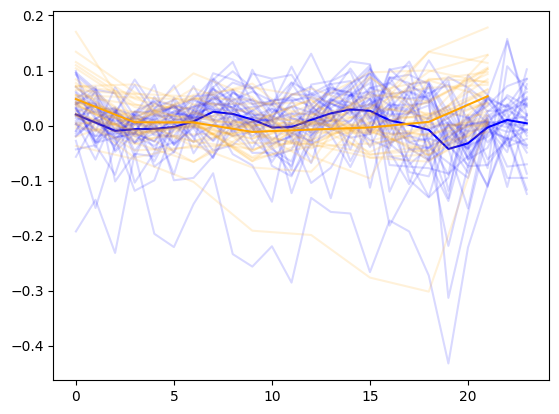

In [ ]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax1 = plt.subplots()

# insert hour column
merge_1.insert(
    len(merge_1.columns), "hour", merge_1["time"].dt.hour, allow_duplicates=True
)

individual_groups = merge_1.groupby(["station_id", "hour"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"],
        c="blue",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

time_group = merge_1.groupby(["hour"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"].values, c="b")

# insert hour column
merge2.insert(
    len(merge2.columns), "hour", merge2["time"].dt.hour, allow_duplicates=True
)
individual_groups = merge2.groupby(["station_id", "hour"]).mean()
for idx, station_id in enumerate(
    individual_groups.index.get_level_values("station_id").unique()
):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(
        sub_df.index,
        sub_df["precipitation_error"] / 3,
        c="orange",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

time_group = merge2.groupby(["hour"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"].values / 3, c="orange")

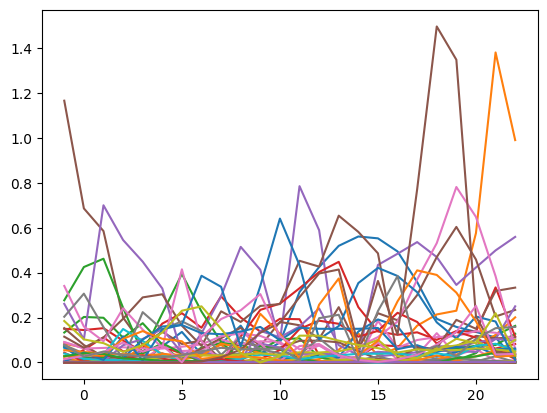

In [ ]:
from scipy.stats import linregress

merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# fig, ax1 = plt.subplots(subplot_kw={'projection': 'polar'})
fig, ax1 = plt.subplots()


# insert column
merge_1.insert(
    len(merge_1.columns), "hour", merge_1["time"].dt.hour, allow_duplicates=True
)

first_call_time = merge_1["call_time"].unique()[0]
# station_data = merge1[(merge1["station_id"] == STATION_ID) & (merge1["call_time"] == first_call_time)].sort_values(by="time")
# station_data = merge1[(merge1["station_id"] == STATION_ID)].groupby("time").mean()
station_data = merge_1.groupby("time").mean()
# ax1.plot(station_data["time"], station_data["precipitation_forecast"])

# values = station_data["precipitation_error"].values.reshape(3, len(station_data) // 3).T
# t = station_data["hour"].values.reshape(3, len(station_data) // 3)
t = station_data["hour"].values
t[t == 23] = -1
index = np.where(t == -1)[0]
t = np.split(t, index)
values = station_data["precipitation_error"].values
values = np.split(values, index)

for t, v in zip(t, values):
    ax1.plot(t, np.abs(v))

# ax1.set_yscale("log")
# t
# time_group_slope = merge2.groupby(["station_id", "time"]).apply(lin_reg)
# for idx, station_id in enumerate(time_group_slope.index.get_level_values("station_id").unique()):
#     sub_df = time_group_slope.xs(station_id, level="station_id")
#     slope, intercept, r_2 = zip(*sub_df.values)
#     ax1.plot(sub_df.index, slope, c="blue", alpha=0.15, label="slope" if not idx else "")
#     # ax1.plot(sub_df.index, intercept, c="green", alpha=0.15, label="intercept" if not idx else "")
#     ax1.plot(sub_df.index, r_2, c="orange", alpha=0.15, label="difference per station model 2" if not idx else "")

change of forecast


/home/robin/miniconda3/envs/DataLiteracy/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/robin/miniconda3/envs/DataLiteracy/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/robin/miniconda3/envs/DataLiteracy/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_6519/1021152985.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silen

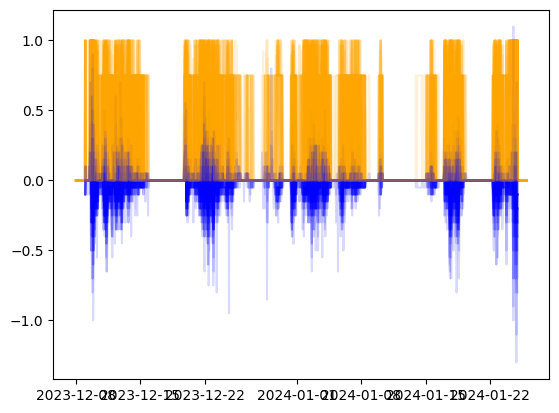

In [ ]:
from scipy.stats import linregress

merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax1 = plt.subplots()


def lin_reg(series):
    if not len(series):
        return 0, 1

    series = series.sort_values(by="call_time")

    x = np.arange(len(series))
    y = series[
        "precipitation_error"
    ].abs()  # expect: negative slope -> the error should go down if we move closer to the prediction time
    # y = series["precipitation_forecast"]  # look if the forecast is more over or under estimating  with the assumption that the error goes down if we move further to the target
    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept, r_value**2


time_group_slope = merge_1.groupby(["station_id", "time"]).apply(lin_reg)
for idx, station_id in enumerate(
    time_group_slope.index.get_level_values("station_id").unique()
):
    sub_df = time_group_slope.xs(station_id, level="station_id")
    slope, intercept, r_2 = zip(*sub_df.values)
    ax1.plot(
        sub_df.index, slope, c="blue", alpha=0.15, label="slope" if not idx else ""
    )
    # ax1.plot(sub_df.index, intercept, c="green", alpha=0.15, label="intercept" if not idx else "")
    ax1.plot(
        sub_df.index,
        r_2,
        c="orange",
        alpha=0.15,
        label="difference per station model 2" if not idx else "",
    )

(257, Timestamp('2023-12-15 00:00:00'))


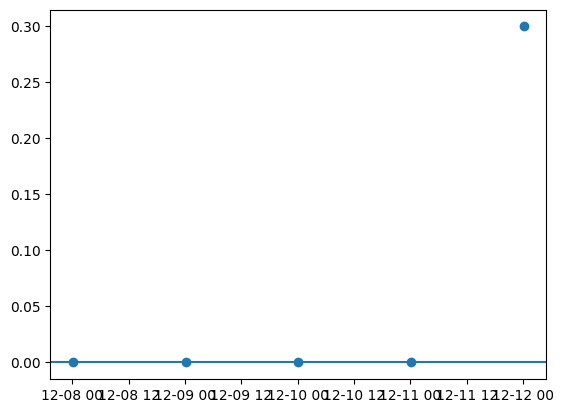

In [ ]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax2 = plt.subplots()


for index, values in merge2.groupby(["station_id", "time"]):
    if len(values) < 5:
        continue
    print(index)
    ax2.scatter(values["call_time"], values["precipitation_forecast"])
    ax2.axhline(values["precipitation_real"].values[0])
    break

In [ ]:
import pandas as pd


merge_1 = dataset_model_1.get_merge(
    columns=[
        "time",
        "call_time",
        "station_id",
        "precipitation_real",
        "precipitation_forecast",
    ]
)
merge2 = dataset_model_2.get_merge(
    columns=[
        "time",
        "call_time",
        "station_id",
        "precipitation_real",
        "precipitation_forecast",
    ]
)

# normalize calltime
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()

# scale merge2
merge2["precipitation_forecast"] = merge2["precipitation_forecast"] / 3
merge2["precipitation_real"] = merge2["precipitation_real"] / 3

# shrink dataset with only precipitation  features in columns
merge3 = pd.merge(merge_1, merge2, how="inner", on=["time", "station_id"])
merge3 = merge3.dropna()  # there is one station without real data

# sort by call time for short-term forecast
merge3 = merge3.sort_values(by="time")


def lin_reg(series: pd.DataFrame):
    forecast1 = series[
        ["call_time_x", "precipitation_forecast_x", "precipitation_real_x"]
    ]
    forecast2 = series[
        ["call_time_y", "precipitation_forecast_y", "precipitation_real_y"]
    ]

    # rename column
    forecast1 = forecast1.rename(
        columns={
            "call_time_x": "call_time",
            "precipitation_forecast_x": "precipitation_forecast",
            "precipitation_real_x": "precipitation_real",
        }
    )
    forecast2 = forecast2.rename(
        columns={
            "call_time_y": "call_time",
            "precipitation_forecast_y": "precipitation_forecast",
            "precipitation_real_y": "precipitation_real",
        }
    )

    forecast2 = forecast2.drop_duplicates()
    forecast1 = forecast1.drop_duplicates()

    concat = pd.concat([forecast1, forecast2]).sort_values(by="call_time")

    t = np.arange(len(concat))
    error = np.abs(
        (concat["precipitation_forecast"] - concat["precipitation_real"]).values
    )
    slope, intercept, r_value, p_value, std_err = linregress(t, error)

    lin_reg_columns = [
        "slope",
        "intercept",
        "r_value",
        "p_value",
        "std_err",
        "num_samples",
    ]
    lin_reg_series = pd.Series(
        index=lin_reg_columns,
        data=[slope, intercept, r_value, p_value, std_err, len(concat)],
    )
    return lin_reg_series


lin_reg_df = merge3.groupby(["time", "station_id"]).apply(lin_reg)

/tmp/ipykernel_6519/42551153.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lin_reg_df = merge3.groupby(["time", "station_id"]).apply(lin_reg)


                                   slope  intercept   r_value   p_value  \
time                station_id                                            
2023-12-17 00:00:00 257         0.000000   0.000000  0.000000  1.000000   
                    259         0.000000   0.000000  0.000000  1.000000   
                    755         0.000000   0.000000  0.000000  1.000000   
                    757         0.000000   0.000000  0.000000  1.000000   
                    1197        0.000000   0.000000  0.000000  1.000000   
...                                  ...        ...       ...       ...   
2024-01-23 21:00:00 6262       -0.006465   0.295758 -0.207600  0.564946   
                    6263        0.022424  -0.010909  0.709834  0.021467   
                    6275        0.009697   0.196364  0.223636  0.534538   
                    7331        0.003636   0.283636  0.042719  0.906722   
                    13965       0.005051   0.173939  0.064383  0.859744   

                        

TypeError: Cannot index by location index with a non-integer key

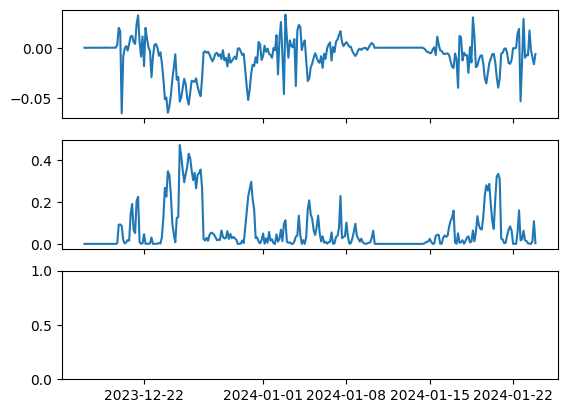

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)

# cut every point which has not the max length
max_length = max(lin_reg_df["num_samples"])
lin_reg_df = lin_reg_df[lin_reg_df["num_samples"] >= (max_length - 1)]
print(lin_reg_df)
mean = lin_reg_df.groupby("time").mean()
t = mean.index
ax1.plot(t, mean["slope"])
ax2.plot(t, mean["r_value"] ** 2)
# ax3.plot(mean.index, mean["num_samples"])
time_mean = merge_1.groupby("time").mean()
print(time_mean.iloc[0])
precipitation_real = time_mean.loc[time_mean.iloc["time"], "precipitation_real"]
ax3.plot(time_mean.index, precipitation_real)
ax3.plot(time_mean.index[1:], np.abs(np.diff(precipitation_real.values)))

In [ ]:
import pandas as pd

# Create a sample DataFrame
data = {
    "Category": ["A", "A", "B", "B", "A", "B"],
    "Value": [10, 15, 20, 18, 25, 22],
    "Value2": [11, 15, 21, 19, 25, 23],
}
df = pd.DataFrame(data)


# Define a custom aggregate function
def custom_aggregate(series):
    print(series)
    print("_____")
    return series.max() - series.min()


# Apply the custom aggregate function using groupby and aggregate
result = df.groupby("Category").aggregate(custom_aggregate)

print(result)

0    10
1    15
4    25
Name: Value, dtype: int64
_____
2    20
3    18
5    22
Name: Value, dtype: int64
_____
0    11
1    15
4    25
Name: Value2, dtype: int64
_____
2    21
3    19
5    23
Name: Value2, dtype: int64
_____
          Value  Value2
Category               
A            15      14
B             4       4


In [ ]:
def get_delta_seconds(series):
    return series.total_seconds()

       precipitation_forecast  air_temperature_forecast  precipitation_real  \
0                         0.1                       NaN                 0.0   
1                         0.0                       NaN                 0.0   
2                         0.0                       NaN                 0.0   
3                         0.0                       NaN                 0.0   
4                         0.0                       NaN                 0.0   
...                       ...                       ...                 ...   
90427                     0.1                       NaN                 2.1   
90428                     1.5                       NaN                 0.0   
90429                     2.3                       NaN                 0.0   
90430                     1.9                       NaN                 1.2   
90431                     1.3                       NaN                 0.1   

       air_temperature_real  precipitation_error  a

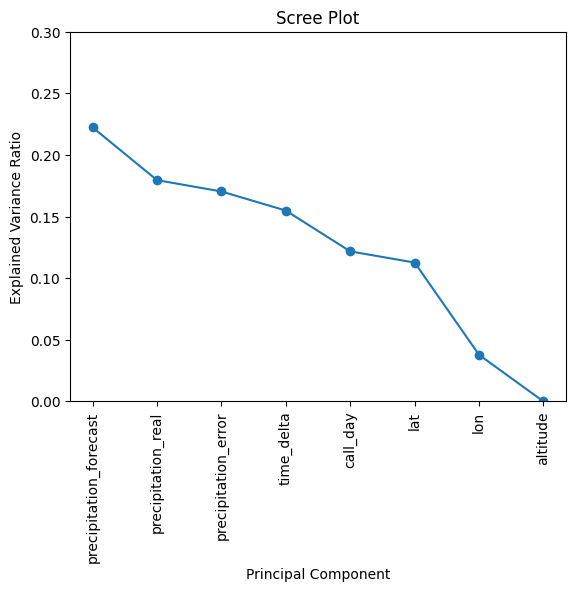

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()
# merge2 = merge2.drop(columns=["air_temperature_forecast", "air_temperature_error"])

merge_1 = merge2

station_meta = dataset_model_1._stations
used_station_ids = merge_1["station_id"].unique()
station_meta = station_meta[
    station_meta["Stations_ID"].isin(used_station_ids)
    & (station_meta["Kennung"] == "MN")
]
coords = station_meta[["Stations_ID", "Breite", "Länge", "Stations-höhe"]]
coords = coords.rename(
    columns={
        "Stations_ID": "station_id",
        "Breite": "lat",
        "Länge": "lon",
        "Stations-höhe": "altitude",
    }
)
# merge1 = merge2

# Extract relevant features from datetime
# merge1["hour"] = merge1["time"].dt.hour
# merge1["day"] = merge1["time"].dt.day
# merge1["month"] = merge1["time"].dt.month
time_delta = (merge_1["time"] - merge_1["call_time"]).apply(get_delta_seconds)
merge_1["time_delta"] = time_delta


merge_1["call_day"] = merge_1["call_time"].dt.day
# merge1["call_month"] = merge1["call_time"].dt.day

merge_1 = pd.merge(merge_1, coords, how="left", on="station_id")

# Drop the original datetime column
merge_1 = merge_1.drop(columns="time")
merge_1 = merge_1.drop(columns="call_time")
merge_1 = merge_1.drop(columns="station_id")

print(merge_1)
merge_1 = merge_1.drop(
    columns=[
        "air_temperature_forecast",
        "air_temperature_real",
        "air_temperature_error",
    ]
)
# merge1 = merge1.drop(columns=["precipitation_forecast", "precipitation_real"])


merge_1

# drop columns with nan
# TODO: there are nans in the data. WHY
print(merge_1.isna().sum(axis=0))
merge_1 = merge_1.dropna()

# Standardize numeric features
numeric_columns = merge_1.columns
scaler = StandardScaler()
merge_1[numeric_columns] = scaler.fit_transform(merge_1[numeric_columns])

# Perform PCA
n_components = 10
# pca = PCA(n_components=n_components)
pca = PCA()
df_pca = pca.fit_transform(merge_1[numeric_columns])

# Print the explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)
print("Cummulative explained variance ratio: ", pca.explained_variance_ratio_.sum())

component_df = pd.DataFrame(pca.components_, columns=pca.feature_names_in_)
variance_df = pd.DataFrame(
    pca.explained_variance_ratio_[None], columns=pca.feature_names_in_
)

import matplotlib.pyplot as plt

fig, ax2 = plt.subplots()

ax2.plot(variance_df.columns, variance_df.values.T, marker="o")
# ax.plot(range(1, len(pca.explained_variance_ratio_) + 1),
#          pca.explained_variance_ratio_, marker='o')
ax2.set_title("Scree Plot")
ax2.set_xlabel("Principal Component")
ax2.set_ylabel("Explained Variance Ratio")
ax2.set_ylim((0, 0.3))
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)

Compute correlation between error and time to forecast?


<Axes: >

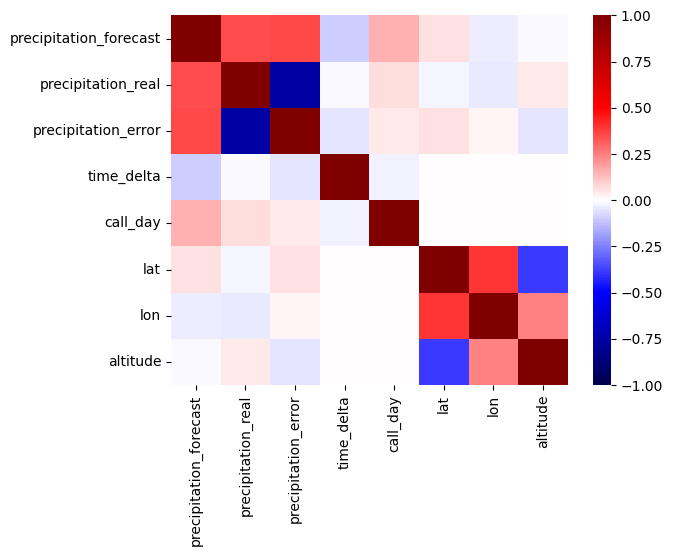

In [ ]:
import seaborn as sn

names = merge_1.columns
corr = merge_1.corr()
# sn.heatmap(corr, cmap="inferno")
sn.heatmap(corr, cmap="seismic", vmin=-1, vmax=1)

In [ ]:
corr

,precipitation_forecast,precipitation_real,precipitation_error,time_delta,call_day,lat,lon,altitude
precipitation_forecast,1.000000,0.347480,0.355155,-9.573655e-02,1.552848e-01,5.650668e-02,-3.497328e-02,-1.352346e-02
precipitation_real,0.347480,1.000000,-0.753148,-1.538958e-02,6.975627e-02,-1.629053e-02,-4.522709e-02,4.210512e-02
precipitation_error,0.355155,-0.753148,1.000000,-5.182337e-02,3.940079e-02,5.588376e-02,2.055204e-02,-5.146341e-02
time_delta,-0.095737,-0.015390,-0.051823,1.000000e+00,-2.854652e-02,-3.496456e-18,1.134384e-18,-3.105437e-18
call_day,0.155285,0.069756,0.039401,-2.854652e-02,1.000000e+00,2.258946e-19,1.491396e-17,-8.120237e-18
lat,0.056507,-0.016291,0.055884,-3.496456e-18,2.258946e-19,1.000000e+00,3.961317e-01,-3.897359e-01
lon,-0.034973,-0.045227,0.020552,1.134384e-18,1.491396e-17,3.961317e-01,1.000000e+00,2.480767e-01
altitude,-0.013523,0.042105,-0.051463,-3.105437e-18,-8.120237e-18,-3.897359e-01,2.480767e-01,1.000000e+00


Calculate rain detection

Question with with threshold can you be sure rain happens


percentage of rain samples:  0.19453154499039613
percentage of rain samples:  0.2711761323425336


Text(0.5, 0.98, 'confusion statistics of precipitation forecast')

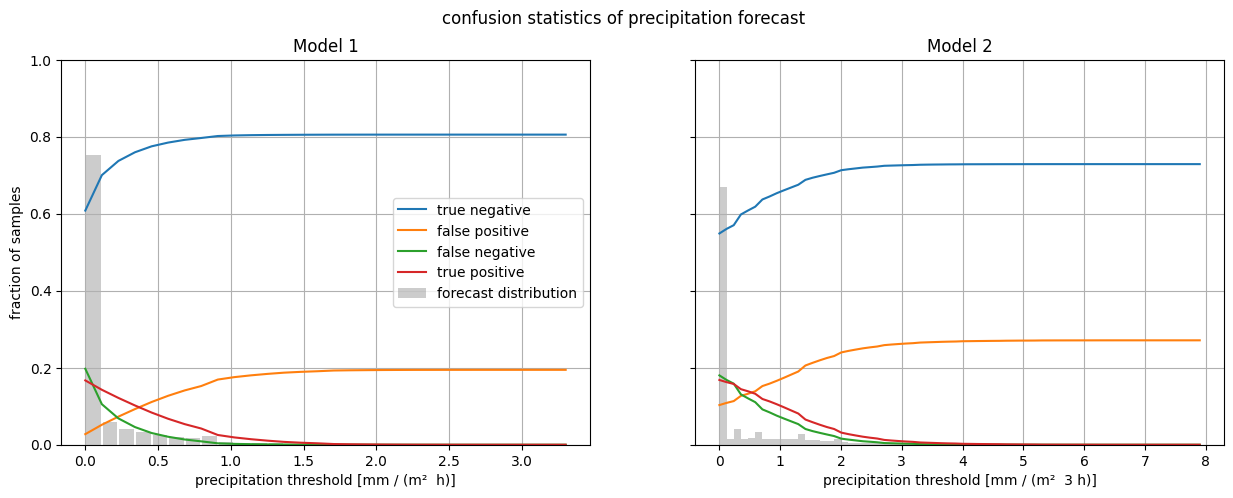

In [ ]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

from sklearn import metrics


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        return int(series > threshold)

    return inner


def create_confusion_matrices(df: pd.DataFrame, num_thresholds: int):
    actual = df["precipitation_real"].transform(bool_mask(0.0)).values
    print("percentage of rain samples: ", actual.sum() / len(actual))
    max_forecast = max(df["precipitation_forecast"])
    thresholds = np.linspace(0, max_forecast, num_thresholds)
    matrices = np.empty((num_thresholds, 2, 2))
    for idx, threshold in enumerate(thresholds):
        predicted = (
            df["precipitation_forecast"]
            .transform(bool_mask(threshold=threshold))
            .values
        )
        matrices[idx] = metrics.confusion_matrix(actual, predicted)

    return thresholds, matrices


unique_forecasts_1 = merge_1["precipitation_forecast"].unique()
unique_forecasts_2 = merge2["precipitation_forecast"].unique()


thresholds1, matrices1 = create_confusion_matrices(merge_1, len(unique_forecasts_1))
thresholds2, matrices2 = create_confusion_matrices(merge2, len(unique_forecasts_2))
counts1 = np.apply_over_axes(np.sum, matrices1, [-2, -1])
counts2 = np.apply_over_axes(np.sum, matrices2, [-2, -1])
matrices1 = np.divide(matrices1, counts1)
matrices2 = np.divide(matrices2, counts2)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)

ax1.plot(thresholds1, matrices1[:, 0, 0], label="true negative")
ax1.plot(thresholds1, matrices1[:, 1, 0], label="false positive")
ax1.plot(thresholds1, matrices1[:, 0, 1], label="false negative")
ax1.plot(thresholds1, matrices1[:, 1, 1], label="true positive")

counts, bins = np.histogram(merge_1["precipitation_forecast"], bins=thresholds1)
density = counts / sum(counts)
bin_width = bins[1] - bins[0]
ax1.bar(
    bins[:-1] + bin_width / 2,
    density,
    zorder=0,
    alpha=0.4,
    width=0.1,
    color="grey",
    label="forecast distribution",
)


ax2.plot(thresholds2, matrices2[:, 0, 0], label="true negative")
ax2.plot(thresholds2, matrices2[:, 1, 0], label="false positive")
ax2.plot(thresholds2, matrices2[:, 0, 1], label="false negative")
ax2.plot(thresholds2, matrices2[:, 1, 1], label="true positive")

counts, bins = np.histogram(merge2["precipitation_forecast"], bins=thresholds2)
density = counts / sum(counts)
bin_width = bins[1] - bins[0]
ax2.bar(
    bins[:-1] + bin_width / 2,
    density,
    zorder=0,
    alpha=0.4,
    width=0.118,
    color="grey",
    label="forecast distribution",
)

ax1.legend()
ax1.set_xlabel("precipitation threshold [mm / (m²  h)]")
ax1.set_ylabel("fraction of samples")
ax1.set_ylim((0, 1))
ax1.set_title("Model 1")
ax1.grid()
ax2.set_title("Model 2")
ax2.set_xlabel("precipitation threshold [mm / (m²  3 h)]")
ax2.grid()
fig.suptitle("confusion statistics of precipitation forecast")

/tmp/ipykernel_6519/2557118093.py:18: RuntimeWarning: invalid value encountered in divide
  recall1 = true_positive_1 / (true_positive_1 + false_negative_1)
/tmp/ipykernel_6519/2557118093.py:20: RuntimeWarning: invalid value encountered in divide
  sensitivity1 = true_positive_1 / (true_positive_1 + false_negative_1)
/tmp/ipykernel_6519/2557118093.py:25: RuntimeWarning: invalid value encountered in divide
  recall2 = true_positive_2 / (true_positive_2 + false_negative_2)
/tmp/ipykernel_6519/2557118093.py:27: RuntimeWarning: invalid value encountered in divide
  sensitivity2 = true_positive_2 / (true_positive_2 + false_negative_2)


Text(0.5, 0.98, 'confusion statistics of precipitation forecast')

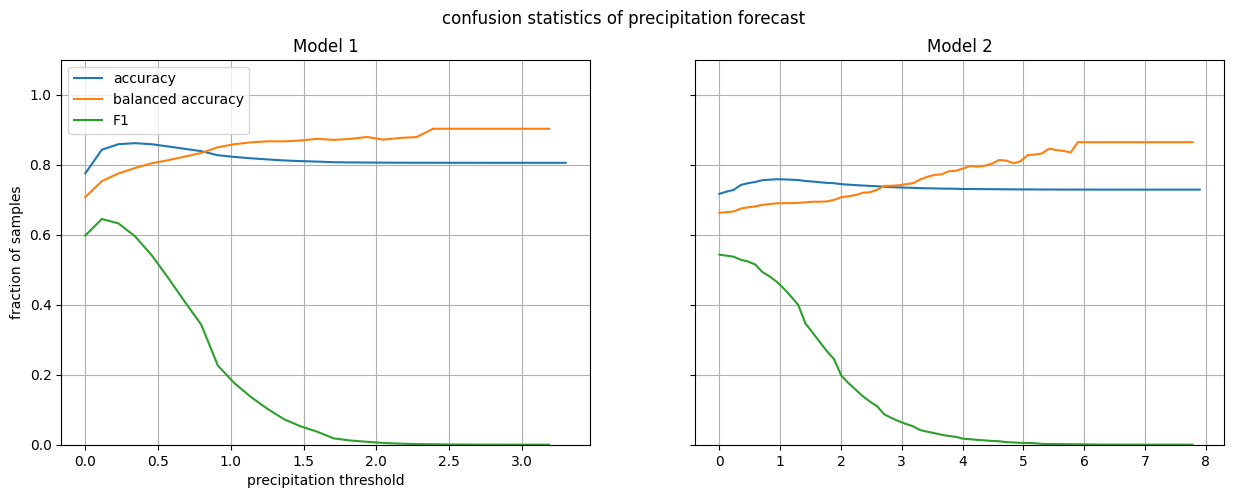

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)

true_negative_1 = matrices1[:, 0, 0]
false_positive_1 = matrices1[:, 1, 0]
false_negative_1 = matrices1[:, 0, 1]
true_positive_1 = matrices1[:, 1, 1]

true_negative_2 = matrices2[:, 0, 0]
false_positive_2 = matrices2[:, 1, 0]
false_negative_2 = matrices2[:, 0, 1]
true_positive_2 = matrices2[:, 1, 1]


accuracy1 = true_positive_1 + true_negative_1
accuracy2 = true_positive_2 + true_negative_2

precision1 = true_positive_1 / (true_positive_1 + false_positive_1)
recall1 = true_positive_1 / (true_positive_1 + false_negative_1)
f1_1 = 2 * precision1 * recall1 / (precision1 + recall1)
sensitivity1 = true_positive_1 / (true_positive_1 + false_negative_1)
specificity1 = true_negative_1 / (true_negative_1 + false_positive_1)
balanced_accuracy1 = (sensitivity1 + specificity1) / 2

precision2 = true_positive_2 / (true_positive_2 + false_positive_2)
recall2 = true_positive_2 / (true_positive_2 + false_negative_2)
f1_2 = 2 * precision2 * recall2 / (precision2 + recall2)
sensitivity2 = true_positive_2 / (true_positive_2 + false_negative_2)
specificity2 = true_negative_2 / (true_negative_2 + false_positive_2)
balanced_accuracy2 = (sensitivity2 + specificity2) / 2


ax1.plot(thresholds1, accuracy1, label="accuracy")
ax2.plot(thresholds2, accuracy2, label="accuracy")
ax1.plot(thresholds1, balanced_accuracy1, label="balanced accuracy")
ax2.plot(thresholds2, balanced_accuracy2, label="balanced accuracy")
# ax1.plot(thresholds1, precision1, label="precision")
# ax2.plot(thresholds2, precision2, label="precision")
# ax1.plot(thresholds1, recall1, label="recall")
# ax2.plot(thresholds2, recall2, label="recall")

ax1.plot(thresholds1, f1_1, label="F1")
ax2.plot(thresholds2, f1_2, label="F1")


ax1.legend()
ax1.set_xlabel("precipitation threshold")
ax1.set_ylabel("fraction of samples")
ax1.set_ylim((0, 1.1))
ax1.set_title("Model 1")
ax2.set_title("Model 2")
ax2.grid()
ax1.grid()
fig.suptitle("confusion statistics of precipitation forecast")

samples per time step into the future: 


(0.7050827423167848, 0.8882978723404256)

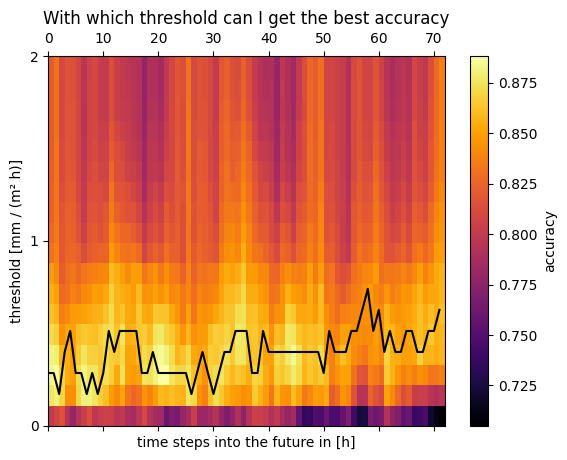

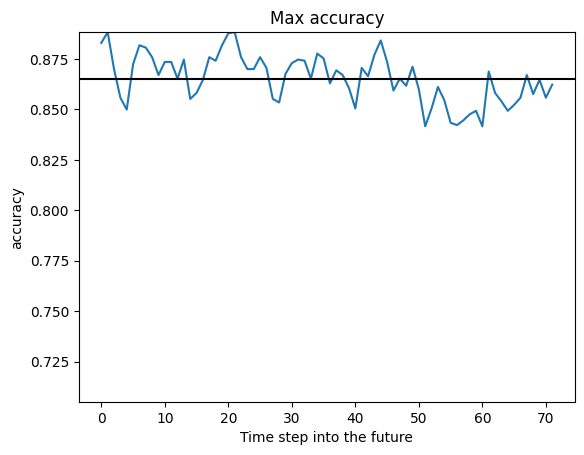

In [ ]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# add time delta
# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        result = series > threshold
        return result

    return inner


# print(merge1.groupby("time_delta")[["precipitation_real", "precipitation_forecast", "precipitation_error"]].aggregate(bool_mask(0.0)))

# set bool mask for actual values
num_thresholds = len(merge_1["precipitation_forecast"].unique())
num_time_deltas = len(merge_1["time_delta"].unique())
max_forecast = max(merge_1["precipitation_forecast"])
thresholds = np.linspace(0, max_forecast, num_thresholds)
matrices = np.empty((num_time_deltas - 1, num_thresholds, 2, 2))
for group_index, (_, group) in enumerate(
    merge_1.groupby("time_delta")[
        ["precipitation_real", "precipitation_forecast", "precipitation_error"]
    ]
):
    actual = group["precipitation_real"].apply(bool_mask(0.0)).values
    if len(group) == 2:
        continue
    for threshold_idx, threshold in enumerate(thresholds):
        transformed = group.apply(bool_mask(threshold=threshold))
        predicted = transformed["precipitation_forecast"].values
        matrices[group_index, threshold_idx] = metrics.confusion_matrix(
            actual, predicted
        )

samples_per_bucket = np.apply_over_axes(np.sum, matrices, [-2, -1])
matrices = np.divide(matrices, samples_per_bucket)

true_negative_1 = matrices[..., 0, 0]
false_positive_1 = matrices[..., 1, 0]
false_negative_1 = matrices[..., 0, 1]
true_positive_1 = matrices[..., 1, 1]


accuracy = (true_positive_1 + true_negative_1).T

print("samples per time step into the future: ")

# accuracy /= accuracy.sum(axis=0)

fig, ax1 = plt.subplots()

extent = [0, 72, max_forecast, 0]
cbar = ax1.matshow(accuracy, extent=extent, cmap="inferno")
ax1.set_aspect("auto")

threshold_bucket_with = thresholds[1]
argmax_threshold = thresholds[accuracy.argmax(axis=0)] + threshold_bucket_with / 2
ax1.plot(argmax_threshold, c="k", label="argmax_threshold")

std_over_time = accuracy.std(axis=0)
ax1.set_ylim((0, 2))
ax1.set_ylabel("threshold [mm / (m² h)]")
ax1.set_xlabel("time steps into the future in [h]")


cbar = fig.colorbar(cbar)
cbar.set_label("accuracy")

std_over_time / max_forecast

ax1.set_title("With which threshold can I get the best accuracy")

fig, ax = plt.subplots()
ax.set_title("Max accuracy")
ax.set_xlabel("Time step into the future")
ax.set_ylabel("accuracy")
ax.plot(
    accuracy.max(axis=0), label="max accuracy"
)  # TODO: adapt y scale to color bar scale
ax.axhline(accuracy.max(axis=0).mean(), c="k")
ax.set_ylim((min(cbar._boundaries), max(cbar._boundaries)))

[1.12014925 0.76641791 0.64850746 1.12014925 0.41268657 0.53059701
 1.00223881 0.76641791 1.2380597  1.00223881 0.88432836 0.88432836
 0.41268657 0.29477612 1.00223881 1.35597015 1.35597015 0.76641791
 0.76641791 0.88432836 0.53059701 0.05895522 1.00223881 1.4738806
 1.35597015 1.00223881 0.76641791 0.76641791 0.29477612 1.00223881
 2.41716418 3.24253731 3.83208955 1.00223881 1.12014925 1.00223881
 1.2380597  1.94552239 3.36044776 2.18134328 1.35597015 1.2380597
 1.82761194 0.88432836 1.00223881 2.41716418 3.24253731 3.00671642
 2.18134328 3.24253731 2.77089552 3.36044776 3.24253731 3.95
 4.42164179 3.83208955]


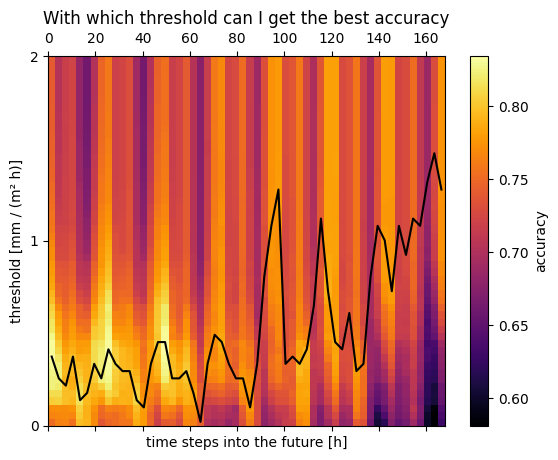

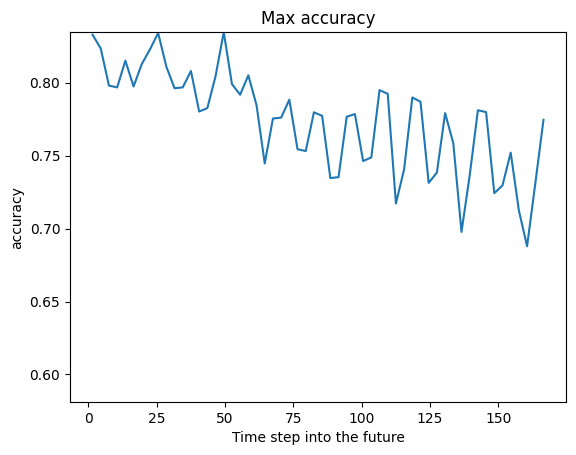

In [ ]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

# add time delta
# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge2["call_time"] = merge2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge2["time"] - merge2["call_time"]
merge2.insert(len(merge2.columns), "time_delta", time_delta)


def bool_mask(threshold: float):
    """everything less or equal to the threshold gets marked as 0
    Else 1

    Args:
        threshold (float):
    """

    def inner(series: pd.Series) -> pd.Series:
        result = series > threshold
        return result

    return inner


# print(merge1.groupby("time_delta")[["precipitation_real", "precipitation_forecast", "precipitation_error"]].aggregate(bool_mask(0.0)))

# set bool mask for actual values
num_thresholds = len(merge2["precipitation_forecast"].unique())
num_time_deltas = len(merge2["time_delta"].unique())
max_forecast = max(merge2["precipitation_forecast"])
thresholds = np.linspace(0, max_forecast, num_thresholds)
matrices = np.empty((num_time_deltas, num_thresholds, 2, 2))
time_deltas = []
for group_index, (time_delta, group) in enumerate(
    merge2.groupby("time_delta")[
        ["precipitation_real", "precipitation_forecast", "precipitation_error"]
    ]
):
    actual = group["precipitation_real"].apply(bool_mask(0.0)).values
    time_deltas.append(time_delta.seconds)
    if len(group) == 2:
        continue
    for threshold_idx, threshold in enumerate(thresholds):
        transformed = group.apply(bool_mask(threshold=threshold))
        predicted = transformed["precipitation_forecast"].values
        matrices[group_index, threshold_idx] = metrics.confusion_matrix(
            actual, predicted
        )
time_deltas = np.array(sorted(time_deltas)) // 3600

samples_per_bucket = np.apply_over_axes(np.sum, matrices, [-2, -1])
# print("samples per time step into the future: ", samples_per_bucket)

matrices = np.divide(matrices, samples_per_bucket)

true_negative_1 = matrices[..., 0, 0]
false_positive_1 = matrices[..., 1, 0]
false_negative_1 = matrices[..., 0, 1]
true_positive_1 = matrices[..., 1, 1]


accuracy = (true_positive_1 + true_negative_1).T


# accuracy /= accuracy.sum(axis=0)

fig, ax2 = plt.subplots()


extent = [0, 56 * 3, max_forecast / 3, 0]
cbar = ax2.matshow(accuracy, extent=extent, cmap="inferno")
ax2.set_aspect("auto")

threshold_bucket_with = thresholds[1]
argmax_threshold = thresholds[accuracy.argmax(axis=0)] + threshold_bucket_with / 2
print(argmax_threshold)
ax2.plot(np.arange(56) * 3 + 1.5, argmax_threshold / 3, c="k", label="argmax_threshold")

ax2.set_ylim((0, 2))
ax2.set_ylabel("threshold [mm / (m² h)]")
ax2.set_xlabel("time steps into the future [h]")


cbar = fig.colorbar(cbar)
cbar.set_label("accuracy")


ax2.set_title("With which threshold can I get the best accuracy")


fig, ax = plt.subplots()
ax.set_title("Max accuracy")
ax.set_xlabel("Time step into the future")
ax.set_ylabel("accuracy")
ax.set_ylim((min(cbar._boundaries), max(cbar._boundaries)))
ax.plot(np.arange(56) * 3 + 1.5, accuracy.max(axis=0))

shape: (128, 9)
┌────────────┬────────────┬───────────┬───────────┬───┬──────────┬───────────┬──────────┬──────────┐
│ forecast_t ┆ true       ┆ false     ┆ false     ┆ … ┆ accuracy ┆ precision ┆ recall   ┆ F-score  │
│ ime_delta_ ┆ positive   ┆ positive  ┆ negative  ┆   ┆ ---      ┆ ---       ┆ ---      ┆ ---      │
│ hours      ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64      ┆ f64       ┆ f64      ┆ f64      │
│ ---        ┆ f64        ┆ f64       ┆ f64       ┆   ┆          ┆           ┆          ┆          │
│ i32        ┆            ┆           ┆           ┆   ┆          ┆           ┆          ┆          │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪══════════╪══════════╡
│ 0          ┆ 0.379433   ┆ 0.099882  ┆ 0.076241  ┆ … ┆ 0.823877 ┆ 0.793594  ┆ 0.833574 ┆ 0.825484 │
│ 1          ┆ 0.391844   ┆ 0.084515  ┆ 0.079196  ┆ … ┆ 0.836288 ┆ 0.823284  ┆ 0.830856 ┆ 0.83045  │
│ 2          ┆ 0.4013     ┆ 0.077423  ┆ 0.086879  ┆ … ┆ 0.835697 ┆ 0.840393

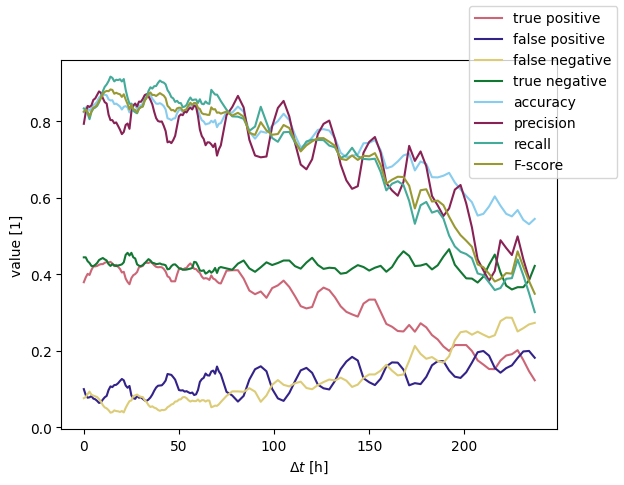

In [ ]:
import datetime
from studies.utils.setup_pyplot import (
    SIDEEFFECTS_setup_tueplot,
    SIDEEFFECTS_choose_color_palette,
    FIG_SAVE_BASE_PATH,
)


join_cols = ["station_id", "time"]

historical = pl.from_pandas(dataset_model_1.get_historical()).sort(join_cols)

# historical_accu = accumulate_timeseries(
#     historical,
#     accumulate_time_step=datetime.timedelta(hours=12),
#     actual_time_step=datetime.timedelta(hours=1),
#     col_to_aggregate=pl.col("precipitation_real"),
#     aggregation_op=pl.col("precipitation_real").sum(),
#     grouped_by=[pl.col("station_id")],
# )
time_col = pl.col("time")

forecast_1 = (
    pl.from_pandas(dataset_model_1.get_forecast())
    .sort(join_cols)
    .with_columns((time_col + datetime.timedelta(hours=1)).alias("time_end"))
)
forecast_2 = (
    pl.from_pandas(dataset_model_2.get_forecast())
    .sort(join_cols)
    .with_columns((time_col + datetime.timedelta(hours=3)).alias("time_end"))
)

# print(historical.sort(join_cols).write_csv("whatever_or.csv"))

forecast = forecast_1.vstack(forecast_2)

forecast_time_delta_expr = (
    (((pl.col("time") - pl.col("call_time")) / datetime.timedelta(hours=1)).round())
    .cast(pl.datatypes.Int32)
    .alias("forecast_time_delta_hours")
)

accumulation_timewindow = datetime.timedelta(hours=12)

# for some reason floating point accuracy messed up our 0.0 for some accumulations.
# so we remove that issue. Originally both forecast and historical data were given as integer as original value times 10.
# we go there for accumulation, and then back again
integerify_precipitation = (pl.col("^precipitation_.*$") * 10).cast(
    pl.datatypes.Int32
)
floatify_precipitation = (
    pl.col("^precipitation_.*$").cast(pl.datatypes.Float64) / 10
)
forecast = forecast.with_columns(integerify_precipitation)

forecast = (
    forecast.rolling(
        time_col,
        period=accumulation_timewindow,
        by=["station_id", "call_time"],
        closed="left",
        offset=datetime.timedelta(),
    )
    .agg(pl.col("precipitation_forecast").sum())
    # we drop the last datapoints, where the accumulation goes over
    # the actually measured time window and assumes 0 for all values in there
    .with_columns(forecast_time_delta_expr)
    # .sort("forecast_time_delta_hours")
    # .slice(offset=0, length=-int(12 / 3))
)

forecast = forecast.with_columns(floatify_precipitation)

historical = historical.with_columns(integerify_precipitation)

historical = (
    historical.rolling(
        time_col,
        period=accumulation_timewindow,
        by=["station_id"],
        closed="left",
        offset=datetime.timedelta(),
    ).agg(pl.col("precipitation_real").sum())
    # .slice(offset=0, length=-int(12 / 1))
)

historical = historical.with_columns(floatify_precipitation)

# print(
# historical.sort(join_cols).write_csv("whatever.csv"),#[13:],
# historical_accu.sort(join_cols).write_csv("whatever2.csv"),
# )

joined = forecast.join(historical, on=join_cols, how="left")

joined = joined.select(
    [
        "station_id",
        "forecast_time_delta_hours",
        "time",
        "call_time",
        "precipitation_real",
        "precipitation_forecast",
    ]
).sort(["station_id", "forecast_time_delta_hours", "time"])

forecast_rain: pl.Expr = (pl.col("precipitation_forecast") > 0.0)
# we always mask actual rain with 0.0!        
actual_rain: pl.Expr = (pl.col("precipitation_real") > 0.0)

test_exprs_1 = {
    "true positive": (forecast_rain & actual_rain).sum() / actual_rain.count(),
    "false positive": (forecast_rain & actual_rain.not_()).sum() / actual_rain.count(),
    "false negative": (forecast_rain.not_() & actual_rain).sum() / actual_rain.count(),
    "true negative": (forecast_rain.not_() & actual_rain.not_()).sum() / actual_rain.count(),
    "accuracy": ((forecast_rain == actual_rain).sum() / forecast_rain.count()),
    "precision": ((forecast_rain & actual_rain).sum() / forecast_rain.sum()),
    "recall": ((forecast_rain & actual_rain).sum() / actual_rain.sum()),
}

test_exprs_2 = {
    "F-score": 2 / (1/pl.col("accuracy") + 1/pl.col("recall")),
}

joined = joined.group_by(["station_id", "forecast_time_delta_hours"]).agg(
    [*[expr.alias(label) for (label, expr) in test_exprs_1.items()]]
)

joined = joined.sort("forecast_time_delta_hours")

joined = joined.with_columns([expr.alias(label) for (label, expr) in test_exprs_2.items()])

all_test_exprs = [
    *test_exprs_1.keys(),
    *test_exprs_2.keys(),
]

joined_agg = joined.group_by("forecast_time_delta_hours").agg(
    pl.col(all_test_exprs).mean(),
)

print(joined_agg)

# SIDEEFFECTS_setup_tueplot(relative_path_to_root=".")

SIDEEFFECTS_choose_color_palette()

fig, ax = plt.subplots()
ax: plt.Axes

for label in all_test_exprs:
    ax.plot(
        joined_agg["forecast_time_delta_hours"].to_numpy(),
        joined_agg.select(label).to_numpy(),
        label=label,
        # zorder=1 if mask_val == 0.0 else -1,
        # c = choosen_palette[idx],
    )

ax.set_xlabel("$\Delta t$ [h]")
ax.set_ylabel("value [1]")  # over all stations and call times

fig.legend()

# fig.savefig(f"{FIG_SAVE_BASE_PATH}/fig_full_statistics.pdf")


shape: (128, 4)
┌────────────────────────┬────────────────────────┬────────────────────────┬───────────────────────┐
│ forecast_time_delta_ho ┆ part_over_0.0_masked_f ┆ part_over_0.5_masked_f ┆ part_over_2.0_masked_ │
│ urs                    ┆ orecast_co…            ┆ orecast_co…            ┆ forecast_co…          │
│ ---                    ┆ ---                    ┆ ---                    ┆ ---                   │
│ i32                    ┆ f64                    ┆ f64                    ┆ f64                   │
╞════════════════════════╪════════════════════════╪════════════════════════╪═══════════════════════╡
│ 0                      ┆ 0.823877               ┆ 0.83747                ┆ 0.761229              │
│ 1                      ┆ 0.836288               ┆ 0.832151               ┆ 0.73818               │
│ 2                      ┆ 0.835697               ┆ 0.828014               ┆ 0.728132              │
│ 3                      ┆ 0.828014               ┆ 0.830969               

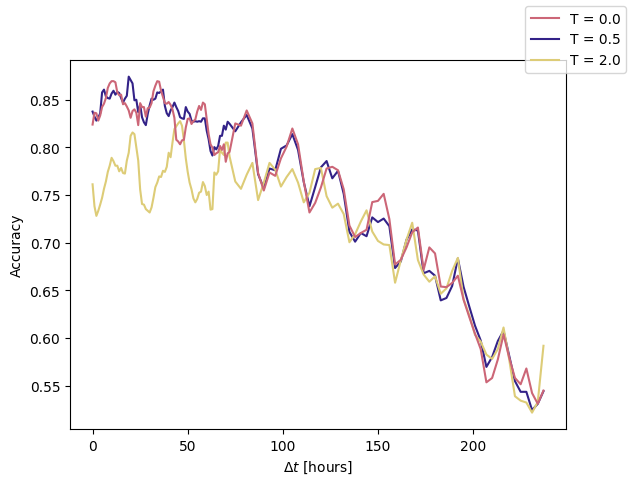

In [ ]:
join_cols = ["station_id", "time"]

historical = pl.from_pandas(dataset_model_1.get_historical()).sort(join_cols)

# historical_accu = accumulate_timeseries(
#     historical,
#     accumulate_time_step=datetime.timedelta(hours=12),
#     actual_time_step=datetime.timedelta(hours=1),
#     col_to_aggregate=pl.col("precipitation_real"),
#     aggregation_op=pl.col("precipitation_real").sum(),
#     grouped_by=[pl.col("station_id")],
# )
time_col = pl.col("time")

forecast_1 = (
    pl.from_pandas(dataset_model_1.get_forecast())
    .sort(join_cols)
    .with_columns((time_col + datetime.timedelta(hours=1)).alias("time_end"))
)
forecast_2 = (
    pl.from_pandas(dataset_model_2.get_forecast())
    .sort(join_cols)
    .with_columns((time_col + datetime.timedelta(hours=3)).alias("time_end"))
)

# print(historical.sort(join_cols).write_csv("whatever_or.csv"))

forecast = forecast_1.vstack(forecast_2)

forecast_time_delta_expr = (
    (((pl.col("time") - pl.col("call_time")) / datetime.timedelta(hours=1)).round())
    .cast(pl.datatypes.Int32)
    .alias("forecast_time_delta_hours")
)

accumulation_timewindow = datetime.timedelta(hours=12)

# for some reason floating point accuracy messed up our 0.0 for some accumulations.
# so we remove that issue. Originally both forecast and historical data were given as integer as original value times 10.
# we go there for accumulation, and then back again
integerify_precipitation = (pl.col("^precipitation_.*$") * 10).cast(
    pl.datatypes.Int32
)
floatify_precipitation = (
    pl.col("^precipitation_.*$").cast(pl.datatypes.Float64) / 10
)
forecast = forecast.with_columns(integerify_precipitation)

forecast = (
    forecast.rolling(
        time_col,
        period=accumulation_timewindow,
        by=["station_id", "call_time"],
        closed="left",
        offset=datetime.timedelta(),
    )
    .agg(pl.col("precipitation_forecast").sum())
    # we drop the last datapoints, where the accumulation goes over
    # the actually measured time window and assumes 0 for all values in there
    .with_columns(forecast_time_delta_expr)
    # .sort("forecast_time_delta_hours")
    # .slice(offset=0, length=-int(12 / 3))
)

forecast = forecast.with_columns(floatify_precipitation)

historical = historical.with_columns(integerify_precipitation)

historical = (
    historical.rolling(
        time_col,
        period=accumulation_timewindow,
        by=["station_id"],
        closed="left",
        offset=datetime.timedelta(),
    ).agg(pl.col("precipitation_real").sum())
    # .slice(offset=0, length=-int(12 / 1))
)

historical = historical.with_columns(floatify_precipitation)

# print(
# historical.sort(join_cols).write_csv("whatever.csv"),#[13:],
# historical_accu.sort(join_cols).write_csv("whatever2.csv"),
# )

joined = forecast.join(historical, on=join_cols, how="left")

mask_vals = [
    0.0,
    # 0.1,
    # 0.2,
    0.5,
    2.0,
    # 5.0,
]

joined = joined.select(
    [
        "station_id",
        "forecast_time_delta_hours",
        "time",
        "call_time",
        "precipitation_real",
        "precipitation_forecast",
    ]
).sort(["station_id", "forecast_time_delta_hours", "time"])

# print(joined.filter(pl.col("forecast_time_delta_hours") == 60))

# time_delt = pl.col("forecast_time_delta_hours")
# # (pl.col("station_id") == 5688) &
# print(joined.filter((61 <= time_delt) & (time_delt <= 71)))

# exit(0)

# we have no prediction for hour 71.
# this is at the border.
# TODO: validate that this is expected
# joined = joined.filter(pl.col("forecast_time_delta_hours") != 71)

# print(
# joined.write_csv("all_data.csv")
# )

for mask_val in mask_vals:
    # we always mask actual rain with 0.0!
    # otherwise the predictions improve, easy to realize with the  limit case of infinity:
    # since we never predict infinitely much rain our prediction is always correct.
    test_expr = (
        (pl.col("precipitation_forecast") > mask_val)
        == (pl.col("precipitation_real") > 0.0)
    ).alias(f"over_{mask_val}_masked_forecast_correct")

    joined = joined.with_columns(
        test_expr,
    )

test_cols = pl.col("^over_.*_masked_forecast_correct$")

correct_pred = (
    joined.group_by(["forecast_time_delta_hours"])
    .agg(
        (
            test_cols.filter(test_cols).count().cast(pl.datatypes.Float64)
            / test_cols.count()
        ).name.prefix("part_")
    )
    .sort("forecast_time_delta_hours")
)

print(correct_pred)

# SIDEEFFECTS_setup_tueplot(relative_path_to_root=".")

SIDEEFFECTS_choose_color_palette()

fig, ax = plt.subplots()
ax: plt.Axes

for mask_val in mask_vals:
    ax.plot(
        correct_pred["forecast_time_delta_hours"].to_numpy(),
        correct_pred[f"part_over_{mask_val}_masked_forecast_correct"].to_numpy(),
        label=f"T = {mask_val}",
        zorder=1 if mask_val == 0.0 else -1,
        # c = choosen_palette[idx],
    )

ax.set_xlabel("$\Delta t$ [hours]")
ax.set_ylabel("Accuracy")  # over all stations and call times

fig.legend()

# fig.savefig(f"{FIG_SAVE_BASE_PATH}/fig_accuracy_thresholds.pdf")


shape: (343_326, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ call_time ┆ station_i ┆ time      ┆ precipita ┆ … ┆ precipita ┆ precipita ┆ precipita ┆ precipit │
│ ---       ┆ d         ┆ ---       ┆ tion_fore ┆   ┆ tion_fore ┆ tion_fore ┆ tion_fore ┆ ation_fo │
│ datetime[ ┆ ---       ┆ datetime[ ┆ cast      ┆   ┆ cast_3h   ┆ cast_6h   ┆ cast_12h  ┆ recast_2 │
│ ns]       ┆ i64       ┆ ns]       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ 4h       │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2023-12-0 ┆ 257       ┆ 2023-12-0 ┆ 0.0       ┆ … ┆ 0.0       ┆ 1.1       ┆ 7.1       ┆ 11.4     │
│ 8         ┆           ┆ 8         ┆           ┆   ┆           ┆     

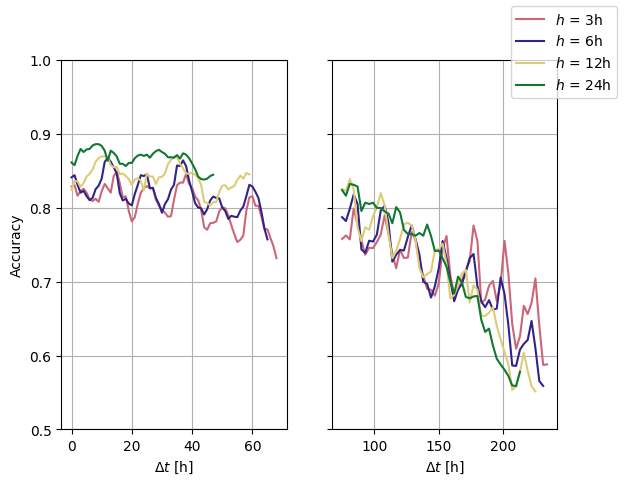

In [ ]:
join_cols = ["station_id", "time"]

historical = pl.from_pandas(dataset_model_1.get_historical()).sort(join_cols)

time_col = pl.col("time")

forecast_1 = (
    pl.from_pandas(dataset_model_1.get_forecast())
    .sort(join_cols)
    .with_columns((time_col + datetime.timedelta(hours=1)).alias("time_end"))
)
forecast_2 = (
    pl.from_pandas(dataset_model_2.get_forecast())
    .sort(join_cols)
    .with_columns((time_col + datetime.timedelta(hours=3)).alias("time_end"))
)

forecast = forecast_1.vstack(forecast_2)

forecast_time_delta_expr = (
    (((pl.col("time") - pl.col("call_time")) / datetime.timedelta(hours=1)).round())
    .cast(pl.datatypes.Int32)
    .alias("forecast_time_delta_hours")
)

delta_time = pl.col("forecast_time_delta_hours")

accumulation_window_hours_selection = [
    3,
    6,
    12,
    24,
]

def get_model_1_data(
    accumulation_window_hours: int,
):
    return (0 <= delta_time) & (delta_time < (72 - accumulation_window_hours))

def get_model_2_data(
    accumulation_window_hours: int,
):
    assert (accumulation_window_hours % 3) == 0
    return (73 <= delta_time) & (
        delta_time < ((10 * 24) - accumulation_window_hours)
    )

# for some reason floating point accuracy messed up our 0.0 for some accumulations.
# so we remove that issue. Originally both forecast and historical data were given as integer as original value times 10.
# we go there for accumulation, and then back again
integerify_precipitation = (pl.col("^precipitation_.*$") * 10).cast(
    pl.datatypes.Int32
)
floatify_precipitation = (
    pl.col("^precipitation_.*$").cast(pl.datatypes.Float64) / 10
)
forecast = forecast.with_columns(integerify_precipitation, forecast_time_delta_expr)
historical = historical.with_columns(integerify_precipitation)

for accumulation_window_hours in accumulation_window_hours_selection:
    accumulation_timewindow = datetime.timedelta(hours=accumulation_window_hours)
    forecast_agg = forecast.rolling(
        time_col,
        period=accumulation_timewindow,
        by=["station_id", "call_time"],
        closed="left",
        offset=datetime.timedelta(),
    ).agg(
        pl.col("precipitation_forecast")
        .sum()
        .name.suffix(f"_{accumulation_window_hours}h")
    )

    historical_agg = (
        historical.rolling(
            time_col,
            period=accumulation_timewindow,
            by=["station_id"],
            closed="left",
            offset=datetime.timedelta(),
        ).agg(
            pl.col("precipitation_real")
            .sum()
            .name.suffix(f"_{accumulation_window_hours}h")
        )
        # .slice(offset=0, length=-int(12 / 1))
    )

    f_join_cols = [*join_cols, "call_time"]
    forecast = forecast.join(
        forecast_agg.select(
            [*f_join_cols, f"precipitation_forecast_{accumulation_window_hours}h"]
        ),
        on=f_join_cols,
        how="left",
    )
    h_join_cols = join_cols
    historical = historical.join(
        historical_agg.select(
            [*h_join_cols, f"precipitation_real_{accumulation_window_hours}h"]
        ),
        on=h_join_cols,
        how="left",
    )

forecast = forecast.with_columns(floatify_precipitation)

historical = historical.with_columns(floatify_precipitation)

print(forecast)

# print(
# historical.sort(join_cols).write_csv("whatever.csv"),#[13:],
# historical_accu.sort(join_cols).write_csv("whatever2.csv"),
# )

joined = forecast.join(historical, on=join_cols, how="left")

joined = (joined
    # .select(
    #     [
    #         "station_id",
    #         "forecast_time_delta_hours",
    #         "time",
    #         "call_time",
    #         "precipitation_real",
    #         "precipitation_forecast",
    #     ]
    # )
    .sort(["station_id", "forecast_time_delta_hours", "time"])
)
# print(joined.filter(pl.col("forecast_time_delta_hours") == 60))

# time_delt = pl.col("forecast_time_delta_hours")
# # (pl.col("station_id") == 5688) &
# print(joined.filter((61 <= time_delt) & (time_delt <= 71)))

# exit(0)

# we have no prediction for hour 71.
# this is at the border.
# TODO: validate that this is expected
# joined = joined.filter(pl.col("forecast_time_delta_hours") != 71)

# print(
# joined.write_csv("all_data.csv")
# )

# SIDEEFFECTS_setup_tueplot(relative_path_to_root=".")

SIDEEFFECTS_choose_color_palette()

fig, [ax1, ax2] = plt.subplots(ncols=2, sharey=True)
ax1: plt.Axes
ax2: plt.Axes

for accumulation_window_hours in accumulation_window_hours_selection:
    test_expr = (
        pl.col(f"precipitation_forecast_{accumulation_window_hours}h") > 0.0
    ) == (pl.col(f"precipitation_real_{accumulation_window_hours}h") > 0.0)

    correct_pred = (
        joined.group_by(["forecast_time_delta_hours"])
        .agg(
            (test_expr.sum().cast(pl.datatypes.Float64) / test_expr.count()).alias(
                f"accuracy_{accumulation_window_hours}h"
            )
        )
        .sort("forecast_time_delta_hours")
    )

    correct_pred_1 = correct_pred.filter(get_model_1_data(accumulation_window_hours))
    correct_pred_2 = correct_pred.filter(get_model_2_data(accumulation_window_hours))

    times_1 = correct_pred_1["forecast_time_delta_hours"]
    times_2 = correct_pred_2["forecast_time_delta_hours"]
    vals_1 = correct_pred_1[f"accuracy_{accumulation_window_hours}h"]
    vals_2 = correct_pred_2[f"accuracy_{accumulation_window_hours}h"]

    ax1.plot(
        times_1.to_numpy(),
        vals_1.to_numpy(),
        label=f"$h$ = {accumulation_window_hours}h",
        # c = choosen_palette[idx],
    )

    ax2.plot(
        times_2.to_numpy(),
        vals_2.to_numpy(),
        # label=f"$\Delta T$ = {accumulation_window_hours}h",
        # c = choosen_palette[idx],
    )

ax1.set_xlabel("$\Delta t$ [h]")
ax2.set_xlabel("$\Delta t$ [h]")
ax1.set_ylabel("Accuracy")  # over all stations and call times

ax1.set_ylim((0.5, 1))
ax1.grid(True)
ax2.grid(True)

fig.legend()

# fig.savefig(f"{FIG_SAVE_BASE_PATH}/fig_accuracy_periods.pdf")


Whats the probability given a certain forecast to really getting wet


In [ ]:
merge_1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

actual = merge_1["precipitation_real"].apply(bool_mask(0))

threshold = 0.2
predition = merge_1["precipitation_forecast"]

relative error to amount of rain $ (forecast - historical) / historical$


Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


given the amount of predicted precipitation whats the expected error


In [ ]:
merge_1 = dataset_model_1.get_merge

Compute on average divergence for a forecast into the future.
Observer how a forecast changes over time

relative error to amount of rain $ (forecast - historical) / historical$


jooy plot for precipitation amount across stations

----> time
|
|
V
station

z: precipitation amount of precipitation
